# Proyek Sistem Rekomendasi Anime [Muhammad Fadel Hamka]

## 1. Project Overview

**Latar Belakang:** Proyek ini bertujuan untuk mengembangkan sistem rekomendasi anime menggunakan dataset "Anime Recommendations Database" dari Kaggle. Fokus utama adalah membantu pengguna mengatasi *information overload* dalam menemukan anime baru yang relevan di tengah banyaknya pilihan, dengan menerapkan teknik *machine learning*.

**Pentingnya Proyek:** Diharapkan sistem ini dapat meningkatkan pengalaman pengguna dengan menyajikan rekomendasi yang dipersonalisasi, mendukung eksplorasi konten yang lebih luas, dan menjadi studi kasus penerapan *machine learning* untuk solusi praktis.

**Pendekatan Utama:** Akan dieksplorasi dua pendekatan utama, yaitu Content-Based Filtering dan Collaborative Filtering, yang merupakan teknik standar dalam sistem rekomendasi (Ricci et al., 2011; Aggarwal, 2016).

## 2. Business Understanding

### Masalah dan Tujuan
* **Masalah Utama:** Pengguna kesulitan menemukan anime yang sesuai selera pribadi karena banyaknya pilihan (*information overload*).
* **Tujuan Utama:**
    1.  Mengurangi kesulitan pengguna dalam menemukan anime baru.
    2.  Memberikan rekomendasi anime yang dipersonalisasi.
    3.  Membantu pengguna menemukan anime dengan karakteristik serupa dengan yang telah disukai.
    4.  Mengembangkan dan mengevaluasi model rekomendasi Content-Based dan Collaborative Filtering.

### Pendekatan Solusi (Solution Approach)
1.  **Content-Based Filtering:** Merekomendasikan anime berdasarkan kemiripan atribut/konten (genre, tipe, dll.).
2.  **Collaborative Filtering:** Merekomendasikan anime berdasarkan pola perilaku dan preferensi pengguna (rating).

## 3. Data Understanding

Tahap ini bertujuan untuk memuat dataset, memahami struktur awalnya, mengidentifikasi variabel-variabel kunci, dan melakukan eksplorasi data awal (Exploratory Data Analysis - EDA) untuk mendapatkan *insight*. Dataset yang digunakan adalah "Anime Recommendations Database" yang terdiri dari dua file utama: `anime.csv` dan `rating.csv`.

### **Import Libraries**

In [ ]:
!pip install -q "numpy<2"
!pip install -q scikit-surprise

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from surprise import Reader, Dataset, SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

#### 1. Persiapan Lingkungan Kaggle API
 Kode di bawah ini bertujuan untuk menginstal library Kaggle dan mengkonfigurasi kunci API (kaggle.json) agar dapat digunakan untuk mengunduh dataset.

In [ ]:
# 1. Instal Kaggle & siapkan direktori API
!pip install -q kaggle
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/  # Pastikan kaggle.json sudah diupload ke Colab
!chmod 600 /root/.kaggle/kaggle.json

#### 2. Membuat Folder dan Mengunduh Dataset Anime
  Selanjutnya, kita akan membuat folder khusus untuk menyimpan dataset dan kemudian mengunduh serta mengekstrak dataset "Anime Recommendations Database" dari Kaggle ke dalamnya.

In [ ]:
# 2. Buat folder dataset & download
dataset_folder = "anime_dataset"
!mkdir -p {dataset_folder}
!kaggle datasets download -d cooperunion/anime-recommendations-database -p {dataset_folder} --unzip

Dataset URL: https://www.kaggle.com/datasets/cooperunion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 981MB/s]


#### 3. Memeriksa Isi Folder Dataset (Opsional)
  Langkah ini bersifat opsional, digunakan untuk memastikan bahwa file dataset (anime.csv dan rating.csv) telah berhasil diunduh dan diekstrak ke dalam folder yang benar.

In [ ]:
# 3. (Opsional) Cek isi folder dataset
!ls {dataset_folder}

anime.csv  rating.csv


### **Load Datasets**

In [ ]:
# Path ke folder dataset (sesuaikan jika berbeda)
dataset_folder = "anime_dataset" # Folder tempat dataset diekstrak

try:
    anime_df = pd.read_csv(os.path.join(dataset_folder, 'anime.csv'))
    rating_df = pd.read_csv(os.path.join(dataset_folder, 'rating.csv'))
    print("Datasets loaded successfully!")
except FileNotFoundError:
    print(f"ERROR: Pastikan file 'anime.csv' dan 'rating.csv' ada di folder '{dataset_folder}'.")
    print("Anda mungkin perlu menjalankan kode untuk mengunduh dataset dari Kaggle terlebih dahulu.")

Datasets loaded successfully!


### 3.1. Inspeksi Awal Data Anime (`anime.csv`)
Melihat beberapa baris pertama, informasi umum, statistik deskriptif, dan jumlah nilai unik untuk setiap kolom pada data anime.

In [ ]:
if 'anime_df' in locals():
    print("Informasi Dataset Anime (anime.csv):")
    print("------------------------------------")
    print("\nLima baris pertama:")
    display(anime_df.head())

    print("\nInformasi Kolom:")
    anime_df.info()

    print("\nStatistik Deskriptif (Kolom Numerik):")
    display(anime_df.describe())

    print("\nStatistik Deskriptif (Kolom Kategorikal/Object):")
    display(anime_df.describe(include='object'))

    print("\nJumlah Nilai Unik per Kolom:")
    display(anime_df.nunique())
else:
    print("anime_df tidak terdefinisi. Pastikan dataset sudah di-load.")

Informasi Dataset Anime (anime.csv):
------------------------------------

Lima baris pertama:


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266



Informasi Kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

Statistik Deskriptif (Kolom Numerik):


,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06



Statistik Deskriptif (Kolom Kategorikal/Object):


,name,genre,type,episodes
count,12294,12232,12269,12294
unique,12292,3264,6,187
top,Shi Wan Ge Leng Xiaohua,Hentai,TV,1
freq,2,823,3787,5677



Jumlah Nilai Unik per Kolom:


,0
anime_id,12294
name,12292
genre,3264
type,6
episodes,187
rating,598
members,6706


*Insight dari Inspeksi `anime_df`:*
* Dataset `anime.csv` berisi 12.294 entri anime.
* Kolom `genre`, `type`, dan `rating` (rata-rata anime) memiliki beberapa nilai yang hilang (missing values).
* Kolom `episodes` memiliki tipe data object karena adanya nilai 'Unknown', yang perlu ditangani.
* Terdapat 12.294 `anime_id` unik, sesuai dengan jumlah baris, menandakan tidak ada duplikasi anime berdasarkan ID.

### 3.2. Inspeksi Awal Data Rating (`rating.csv`)
Melihat beberapa baris pertama, informasi umum, statistik deskriptif, dan jumlah nilai unik untuk setiap kolom pada data rating pengguna.

In [ ]:
if 'rating_df' in locals():
    print("Informasi Dataset Rating (rating.csv):")
    print("-------------------------------------")
    print("\nLima baris pertama:")
    display(rating_df.head())

    print("\nInformasi Kolom:")
    rating_df.info()

    print("\nStatistik Deskriptif:")
    display(rating_df.describe())

    print("\nJumlah Nilai Unik per Kolom:")
    display(rating_df.nunique())

    # Cek nilai unik pada kolom rating untuk melihat adanya -1
    print("\nNilai unik di kolom 'rating' dan jumlahnya:")
    display(rating_df['rating'].value_counts().sort_index())
else:
    print("rating_df tidak terdefinisi. Pastikan dataset sudah di-load.")

Informasi Dataset Rating (rating.csv):
-------------------------------------

Lima baris pertama:


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1



Informasi Kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB

Statistik Deskriptif:


,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01



Jumlah Nilai Unik per Kolom:


,0
user_id,73515
anime_id,11200
rating,11



Nilai unik di kolom 'rating' dan jumlahnya:


,count
rating,
-1,1476496
1,16649
2,23150
3,41453
4,104291
5,282806
6,637775
7,1375287
8,1646019


*Insight dari Inspeksi `rating_df`:*
* Dataset `rating.csv` memiliki lebih dari 7,8 juta entri rating.
* Semua kolom (`user_id`, `anime_id`, `rating`) bertipe integer dan tidak memiliki missing values.
* Kolom `rating` memiliki nilai dari -1 hingga 10. Nilai -1 menunjukkan anime ditonton tapi tidak diberi rating (sekitar 1,47 juta entri).
* Terdapat 73.515 pengguna unik dan 11.200 anime unik yang memiliki rating.

### 3.3. Deskripsi Variabel

Berikut adalah penjelasan untuk setiap variabel dalam dataset:

**Pada `anime.csv`:**
* `anime_id`: ID unik untuk setiap anime (dari myanimelist.net).
* `name`: Judul lengkap anime.
* `genre`: Daftar genre yang dipisahkan koma untuk anime tersebut.
* `type`: Tipe anime (misalnya, TV, Movie, OVA, Special, ONA, Music).
* `episodes`: Jumlah episode dalam anime (nilai '1' jika tipe Movie). Bisa juga 'Unknown'.
* `rating`: Rating rata-rata anime (skala 1-10) berdasarkan semua pengguna di MyAnimeList.
* `members`: Jumlah anggota komunitas MyAnimeList yang memiliki anime ini dalam daftar mereka.

**Pada `rating.csv`:**
* `user_id`: ID unik yang digenerate secara acak untuk setiap pengguna.
* `anime_id`: ID anime yang dinilai oleh pengguna (merujuk ke `anime_id` di `anime.csv`).
* `rating`: Rating yang diberikan pengguna untuk anime tersebut (skala 1-10). Nilai `-1` berarti pengguna telah menonton anime tersebut tetapi tidak memberikan rating.

### 3.4. Exploratory Data Analysis (EDA)
Melakukan analisis eksploratif untuk memahami distribusi data, mengidentifikasi pola, dan menemukan *insight* awal.

#### 3.4.1. EDA pada Data Anime (`anime_df`)

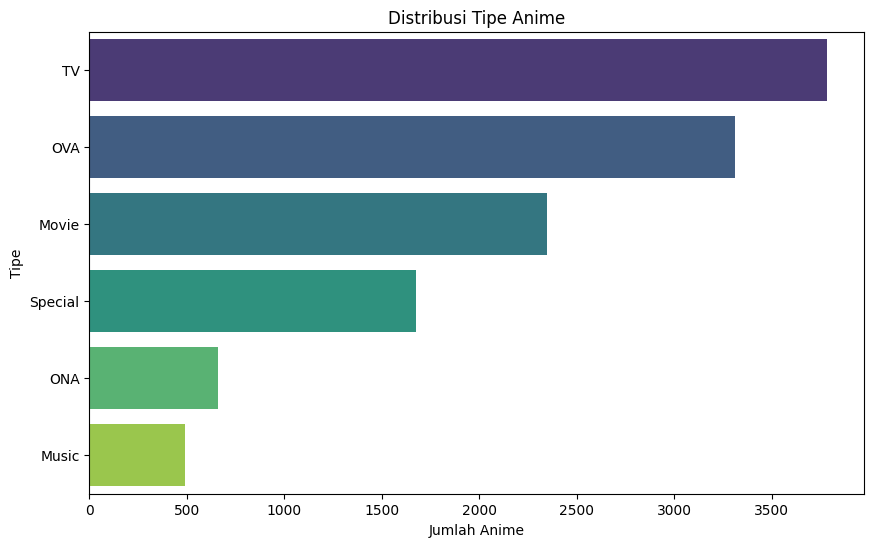


Jumlah anime berdasarkan tipe:


,count
type,
TV,3787
OVA,3311
Movie,2348
Special,1676
ONA,659
Music,488


In [ ]:
# Distribusi Tipe Anime
if 'anime_df' in locals():
    plt.figure(figsize=(10, 6))
    sns.countplot(y='type', data=anime_df, order = anime_df['type'].value_counts().index, palette='viridis')
    plt.title('Distribusi Tipe Anime')
    plt.xlabel('Jumlah Anime')
    plt.ylabel('Tipe')
    plt.show()

    print("\nJumlah anime berdasarkan tipe:")
    display(anime_df['type'].value_counts())
else:
    print("anime_df tidak terdefinisi.")

*Insight Distribusi Tipe Anime:*
* Tipe anime yang paling umum dalam dataset adalah 'TV' (lebih dari 3700 anime), diikuti oleh 'OVA' dan 'Movie'.
* Tipe 'Music' memiliki jumlah paling sedikit.

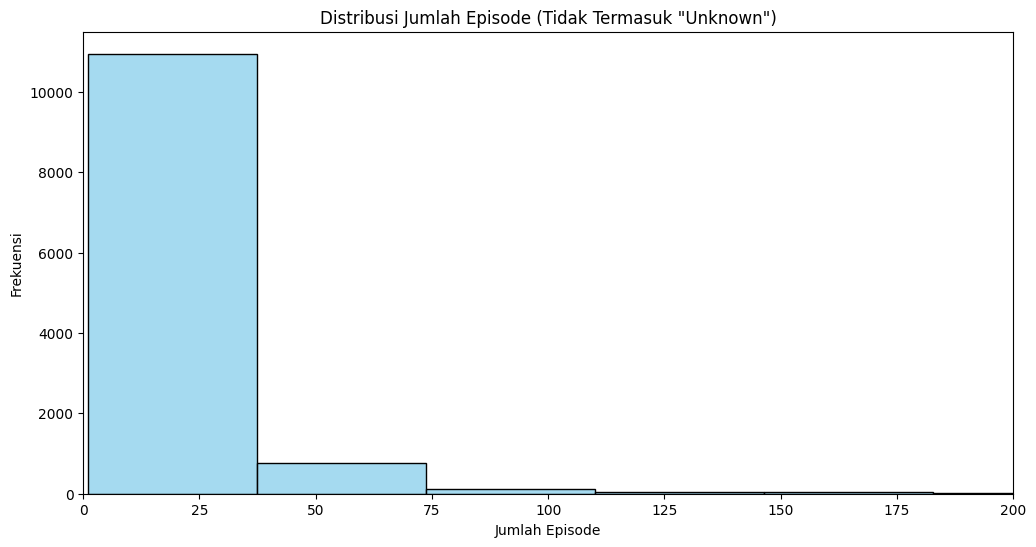


Statistik deskriptif untuk jumlah episode (numerik):


,episodes_numeric
count,11954.000000
mean,12.382550
std,46.865352
min,1.000000
25%,1.000000
50%,2.000000
75%,12.000000
max,1818.000000



Jumlah anime dengan jumlah episode 'Unknown': 340


In [ ]:
# Distribusi Jumlah Episode
if 'anime_df' in locals():
    # Mengganti 'Unknown' dengan NaN agar bisa diubah ke numerik dan diabaikan dalam plot numerik
    anime_df['episodes_numeric'] = pd.to_numeric(anime_df['episodes'], errors='coerce')

    plt.figure(figsize=(12, 6))
    sns.histplot(anime_df['episodes_numeric'].dropna(), bins=50, kde=False, color='skyblue')
    plt.title('Distribusi Jumlah Episode (Tidak Termasuk "Unknown")')
    plt.xlabel('Jumlah Episode')
    plt.ylabel('Frekuensi')
    plt.xlim(0, 200) # Batasi x-axis untuk visualisasi yang lebih baik, mayoritas anime pendek
    plt.show()

    print("\nStatistik deskriptif untuk jumlah episode (numerik):")
    display(anime_df['episodes_numeric'].describe())

    unknown_episodes_count = anime_df['episodes'].value_counts().get('Unknown', 0)
    print(f"\nJumlah anime dengan jumlah episode 'Unknown': {unknown_episodes_count}")
else:
    print("anime_df tidak terdefinisi.")

*Insight Distribusi Jumlah Episode:*
* Sebagian besar anime memiliki jumlah episode yang relatif pendek (median 2 episode, 75% di bawah 12 episode). Ini dipengaruhi oleh anime tipe 'Movie' (1 episode) dan serial pendek.
* Terdapat 340 anime dengan jumlah episode 'Unknown', yang perlu ditangani jika fitur ini akan digunakan secara numerik.

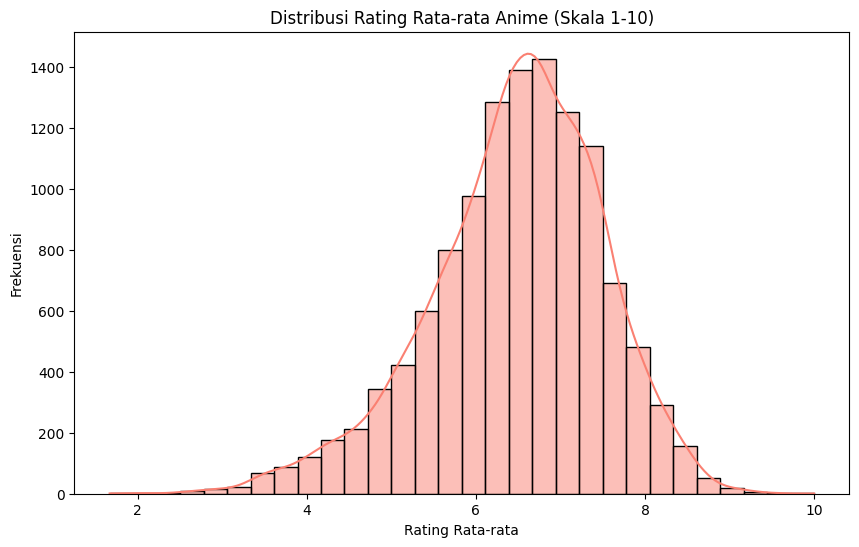


Statistik deskriptif untuk rating rata-rata anime:


,rating
count,12064.000000
mean,6.473902
std,1.026746
min,1.670000
25%,5.880000
50%,6.570000
75%,7.180000
max,10.000000


In [ ]:
# Distribusi Rating Rata-rata Anime
if 'anime_df' in locals():
    plt.figure(figsize=(10, 6))
    sns.histplot(anime_df['rating'].dropna(), bins=30, kde=True, color='salmon')
    plt.title('Distribusi Rating Rata-rata Anime (Skala 1-10)')
    plt.xlabel('Rating Rata-rata')
    plt.ylabel('Frekuensi')
    plt.show()

    print("\nStatistik deskriptif untuk rating rata-rata anime:")
    display(anime_df['rating'].describe())
else:
    print("anime_df tidak terdefinisi.")

*Insight Distribusi Rating Rata-rata Anime:*
* Rating rata-rata anime (skala 1-10) terdistribusi mendekati normal, dengan puncak di sekitar 6.57 (median).
* Sebagian besar anime memiliki rating rata-rata antara 5.88 (Q1) dan 7.18 (Q3).

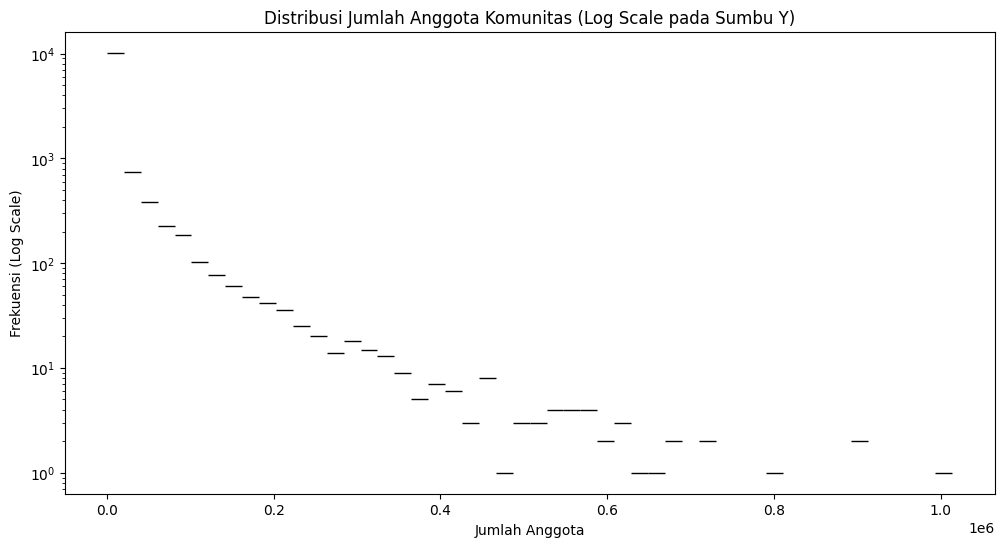


Statistik deskriptif untuk jumlah anggota:


,members
count,1.229400e+04
mean,1.807134e+04
std,5.482068e+04
min,5.000000e+00
25%,2.250000e+02
50%,1.550000e+03
75%,9.437000e+03
max,1.013917e+06


In [ ]:
# Distribusi Jumlah Anggota Komunitas)
if 'anime_df' in locals():
    plt.figure(figsize=(12, 6))
    # Menggunakan log scale karena distribusinya sangat skewed
    sns.histplot(anime_df['members'], bins=50, kde=False, color='lightgreen', log_scale=(False, True))
    plt.title('Distribusi Jumlah Anggota Komunitas (Log Scale pada Sumbu Y)')
    plt.xlabel('Jumlah Anggota')
    plt.ylabel('Frekuensi (Log Scale)')
    plt.show()

    print("\nStatistik deskriptif untuk jumlah anggota:")
    display(anime_df['members'].describe())
else:
    print("anime_df tidak terdefinisi.")

*Insight Distribusi Jumlah Anggota Komunitas:*
* Distribusi jumlah anggota sangat condong ke kanan (right-skewed), bahkan saat divisualisasikan dengan skala log pada sumbu Y.
* Ini menunjukkan bahwa sebagian kecil anime sangat populer (memiliki banyak anggota), sementara mayoritas anime memiliki jumlah anggota yang jauh lebih sedikit.

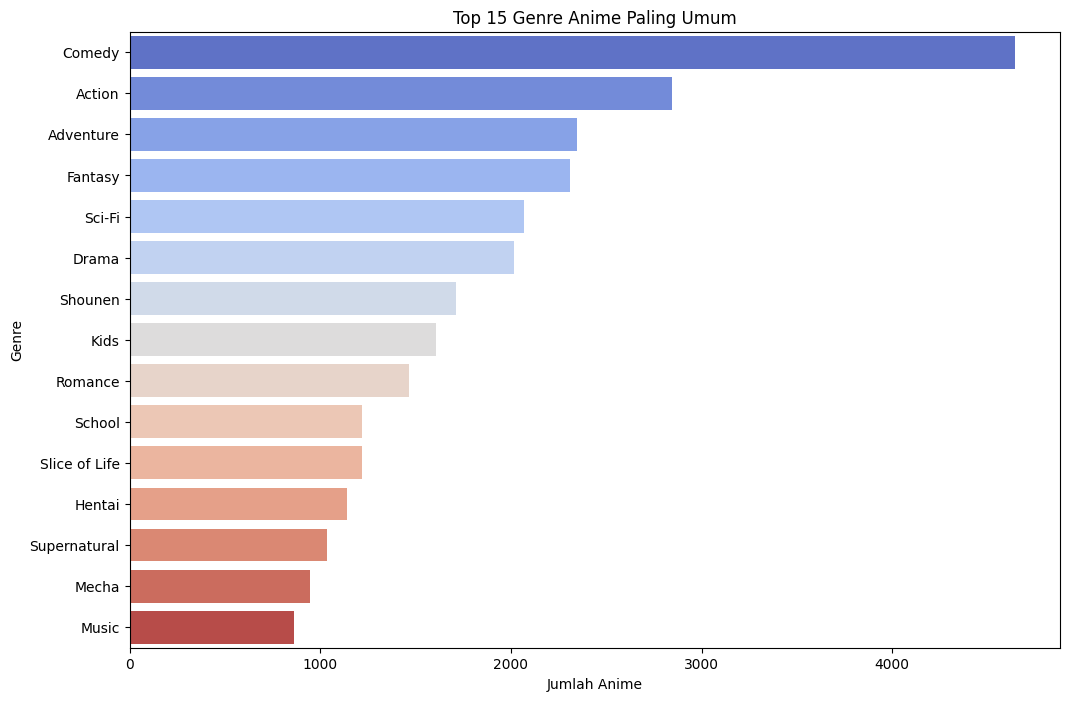


Top 15 Genre Anime:
- Comedy: 4645
- Action: 2845
- Adventure: 2348
- Fantasy: 2309
- Sci-Fi: 2070
- Drama: 2016
- Shounen: 1712
- Kids: 1609
- Romance: 1464
- School: 1220
- Slice of Life: 1220
- Hentai: 1141
- Supernatural: 1037
- Mecha: 944
- Music: 860


In [ ]:
# Analisis Genre Anime)
if 'anime_df' in locals():
    # Menghilangkan baris dengan genre NaN sebelum melakukan split
    genre_df = anime_df.dropna(subset=['genre'])

    # Menggabungkan semua genre menjadi satu list besar
    all_genres = []
    for genres in genre_df['genre']:
        all_genres.extend(genres.split(', ')) # Split berdasarkan ', '

    # Menghitung frekuensi setiap genre
    genre_counts = Counter(all_genres)
    top_n_genres = 15 # Tampilkan N genre teratas
    common_genres = genre_counts.most_common(top_n_genres)

    # Membuat DataFrame untuk visualisasi
    common_genres_df = pd.DataFrame(common_genres, columns=['Genre', 'Jumlah'])

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Jumlah', y='Genre', data=common_genres_df, palette='coolwarm')
    plt.title(f'Top {top_n_genres} Genre Anime Paling Umum')
    plt.xlabel('Jumlah Anime')
    plt.ylabel('Genre')
    plt.show()

    print(f"\nTop {top_n_genres} Genre Anime:")
    for genre, count in common_genres:
        print(f"- {genre}: {count}")
else:
    print("anime_df tidak terdefinisi.")

#### 3.4.2. EDA pada Data Rating (`rating_df`)

*Insight Analisis Genre Anime:*
* Genre 'Comedy' adalah yang paling umum, muncul di lebih dari 4600 anime.
* Genre populer lainnya termasuk 'Action', 'Adventure', 'Fantasy', dan 'Sci-Fi'.

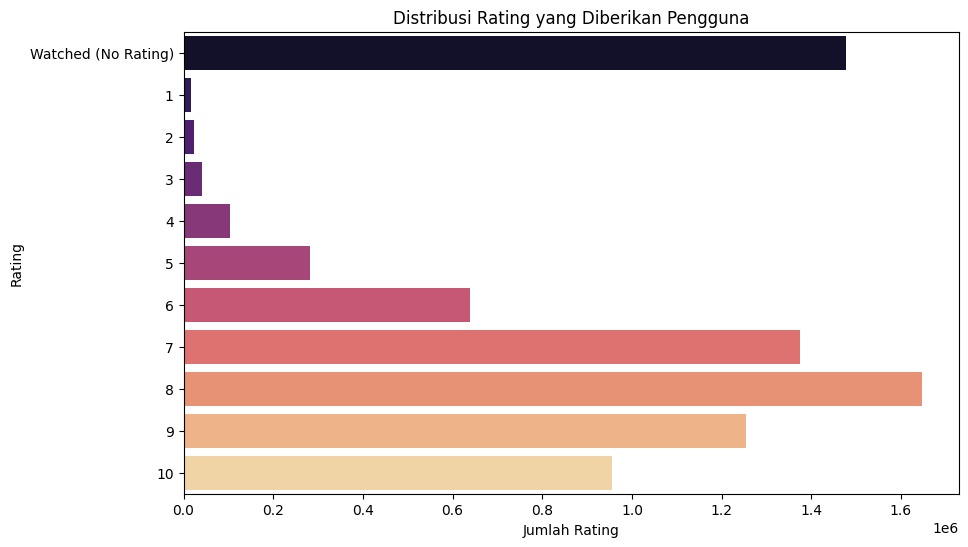


Jumlah rating berdasarkan nilai:


,count
rating,
-1,1476496
1,16649
2,23150
3,41453
4,104291
5,282806
6,637775
7,1375287
8,1646019


In [ ]:
# Distribusi Rating Pengguna)
if 'rating_df' in locals():
    plt.figure(figsize=(10, 6))
    # Mengganti -1 dengan label 'Watched (No Rating)' untuk visualisasi
    rating_display = rating_df['rating'].replace(-1, 'Watched (No Rating)')
    order = sorted(rating_display.unique(), key=lambda x: float(x) if x != 'Watched (No Rating)' else -1)

    sns.countplot(y=rating_display, order=order, palette='magma')
    plt.title('Distribusi Rating yang Diberikan Pengguna')
    plt.xlabel('Jumlah Rating')
    plt.ylabel('Rating')
    plt.show()

    print("\nJumlah rating berdasarkan nilai:")
    display(rating_df['rating'].value_counts().sort_index())
else:
    print("rating_df tidak terdefinisi.")

*Insight Distribusi Rating Pengguna:*
* Pengguna paling sering memberikan rating 7, 8, dan 9.
* Jumlah anime yang 'Watched (No Rating)' (-1) sangat signifikan (sekitar 1,47 juta), menunjukkan banyak interaksi implisit.
* Rating rendah (1-4) lebih jarang diberikan.

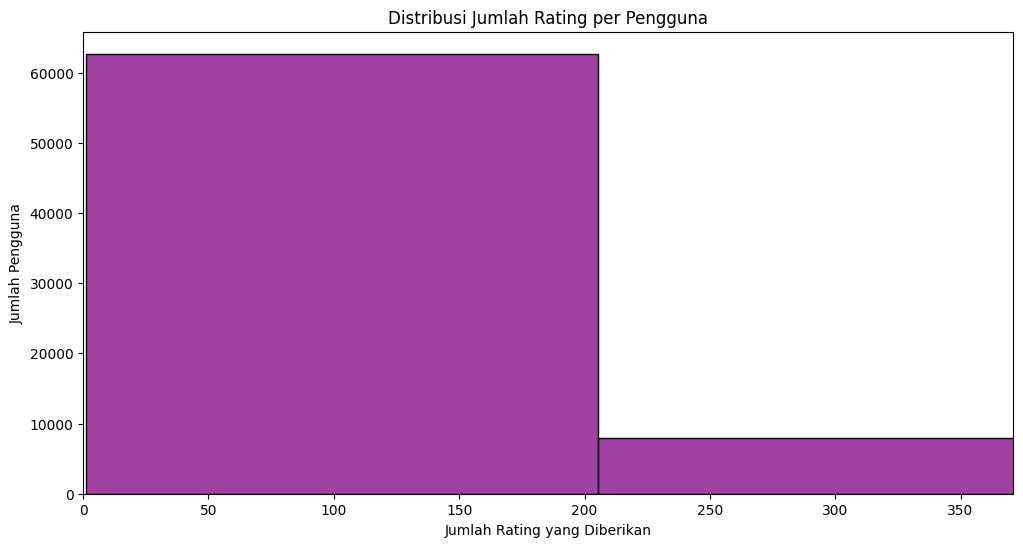


Statistik deskriptif untuk jumlah rating per pengguna:


,rating
count,73515.000000
mean,106.287656
std,153.086558
min,1.000000
25%,18.000000
50%,57.000000
75%,136.000000
max,10227.000000


In [ ]:
# (Jumlah Rating per Pengguna)
if 'rating_df' in locals():
    ratings_per_user = rating_df.groupby('user_id')['rating'].count()

    plt.figure(figsize=(12, 6))
    sns.histplot(ratings_per_user, bins=50, kde=False, color='purple')
    plt.title('Distribusi Jumlah Rating per Pengguna')
    plt.xlabel('Jumlah Rating yang Diberikan')
    plt.ylabel('Jumlah Pengguna')
    plt.xlim(0, ratings_per_user.quantile(0.95)) # Fokus pada 95% pengguna untuk visualisasi lebih baik
    plt.show()

    print("\nStatistik deskriptif untuk jumlah rating per pengguna:")
    display(ratings_per_user.describe())
else:
    print("rating_df tidak terdefinisi.")

*Insight Jumlah Rating per Pengguna:*
* Distribusi jumlah rating yang diberikan per pengguna juga condong ke kanan.
* Banyak pengguna memberikan relatif sedikit rating (median 57 rating), sementara beberapa pengguna sangat aktif memberikan banyak rating. Ini mengindikasikan potensi masalah *sparsity* untuk model Collaborative Filtering.

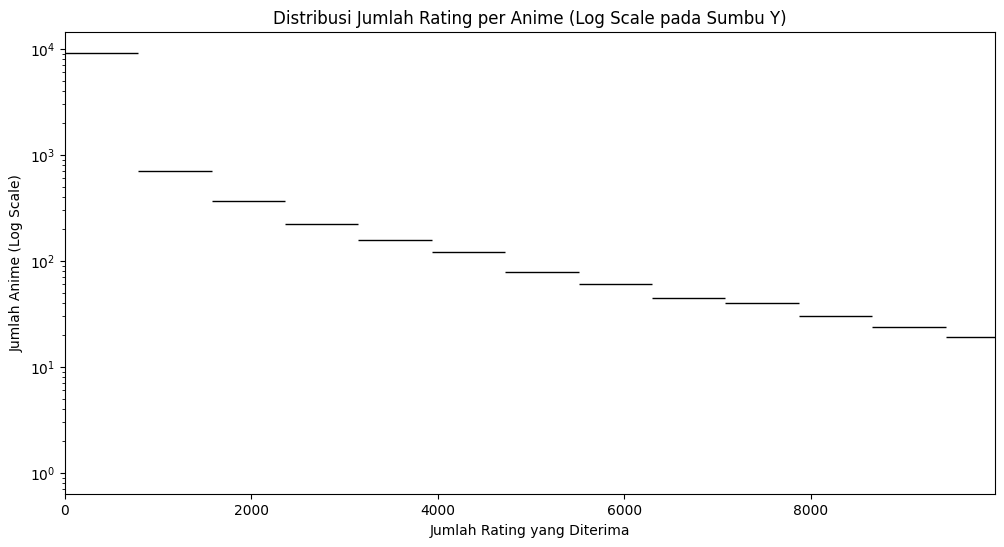


Statistik deskriptif untuk jumlah rating per anime:


,rating
count,11200.000000
mean,697.655089
std,2028.627749
min,1.000000
25%,5.000000
50%,51.500000
75%,385.250000
max,39340.000000


In [ ]:
# Jumlah Rating per Anime)
if 'rating_df' in locals():
    ratings_per_anime = rating_df.groupby('anime_id')['rating'].count()

    plt.figure(figsize=(12, 6))
    sns.histplot(ratings_per_anime, bins=50, kde=False, color='orange', log_scale=(False, True))
    plt.title('Distribusi Jumlah Rating per Anime (Log Scale pada Sumbu Y)')
    plt.xlabel('Jumlah Rating yang Diterima')
    plt.ylabel('Jumlah Anime (Log Scale)')
    plt.xlim(0, ratings_per_anime.quantile(0.99)) # Fokus pada 99% anime
    plt.show()

    print("\nStatistik deskriptif untuk jumlah rating per anime:")
    display(ratings_per_anime.describe())
else:
    print("rating_df tidak terdefinisi.")

*Insight Jumlah Rating per Anime:*
* Distribusi jumlah rating yang diterima per anime sangat condong ke kanan (long-tail).
* Sebagian kecil anime menerima sangat banyak rating (sangat populer), sementara mayoritas anime hanya menerima sedikit rating (median sekitar 51 rating). Ini juga relevan untuk masalah *sparsity* dan *cold-start* pada item.

### 3.5. Ringkasan Temuan Data Understanding

* **Dataset Anime (`anime.csv`):**
    * Memiliki **12.294 entri anime unik**.
    * Informasi detail tentang atribut anime mencakup `genre`, `type`, `episodes`, `rating` (rata-rata anime), dan `members`.
    * Terdapat nilai yang hilang (missing values) pada kolom `genre`, `type`, dan `rating` (rata-rata anime).
    * Kolom `episodes` bertipe *object* karena adanya **340 entri bernilai 'Unknown'** yang perlu ditangani jika fitur ini akan digunakan secara numerik. Sebagian besar anime memiliki jumlah episode sedikit (median 2, 75% di bawah 12 episode).
    * Distribusi jumlah `members` sangat condong ke kanan (right-skewed), mengindikasikan bahwa hanya sebagian kecil anime yang sangat populer.
    * Rating rata-rata anime terdistribusi mendekati normal dengan **median sekitar 6.57**.
    * Tipe anime yang paling dominan adalah **'TV'**.

* **Dataset Rating (`rating.csv`):**
    * Berisi lebih dari **7,8 juta entri rating** dari **73.515 pengguna unik** untuk **11.200 anime unik**.
    * Tidak ditemukan missing values pada kolom-kolomnya.
    * Menyimpan interaksi pengguna dengan anime, termasuk rating eksplisit (skala 1-10) dan indikasi telah ditonton tanpa rating (nilai **-1**, yang jumlahnya signifikan, sekitar **1,47 juta entri**).

* **Pola Umum pada Data:**
    * Distribusi data untuk jumlah `members` (anime), jumlah rating per pengguna (median 57 rating/pengguna), dan jumlah rating per anime (median sekitar 51 rating/anime) cenderung **sangat condong ke kanan (right-skewed atau long-tail)**. Ini menunjukkan adanya item/pengguna yang sangat populer/aktif sementara mayoritas lainnya kurang, yang mengarah pada potensi masalah *sparsity*.
    * Genre paling populer antara lain **Comedy (sekitar 4600+ anime), Action (2800+), Adventure (2300+), Fantasy (2300+), dan Sci-Fi (2000+)**.
    * Data rating pengguna menunjukkan preferensi yang kuat pada **skor tinggi (paling banyak rating 7, 8, dan 9)**.

* **Implikasi untuk Tahap Selanjutnya:**
    * Temuan ini akan menjadi dasar krusial untuk tahap **Data Preparation**. Langkah-langkah seperti penanganan missing values, konversi tipe data (misalnya, `episodes`), dan transformasi fitur (misalnya, untuk `genre`) akan diperlukan.
    * Sifat data yang *sparse* dan *skewed* juga perlu dipertimbangkan saat memilih dan mengimplementasikan algoritma model rekomendasi.

## 4. Data Preparation

Tahap Data Preparation bertujuan untuk membersihkan dan mentransformasi data agar siap digunakan untuk proses pemodelan. Berdasarkan temuan dari tahap Data Understanding, beberapa langkah yang akan dilakukan meliputi:
1.  **Penanganan Missing Values:** Mengatasi nilai-nilai yang hilang pada kolom-kolom penting di `anime_df`.
2.  **Pemrosesan Kolom `episodes`:** Mengkonversi kolom `episodes` di `anime_df` menjadi tipe numerik dan menangani nilai 'Unknown'.
3.  **Penanganan Rating `-1`:** Menentukan strategi untuk nilai rating `-1` (watched but no score) di `rating_df`.
4.  **Feature Engineering (untuk Content-Based):**
    * Mengubah kolom `genre` menjadi representasi numerik yang bisa diproses model.
    * Mengubah kolom `type` menjadi representasi numerik.
5.  **Pembersihan Data Tambahan (jika diperlukan):** Memeriksa duplikasi atau inkonsistensi lain.

Langkah-langkah ini krusial untuk memastikan kualitas data yang masuk ke model, yang akan sangat mempengaruhi performa sistem rekomendasi.

In [ ]:
# Membuat Salinan DataFrame
if 'anime_df' in locals() and 'rating_df' in locals():
    anime_prep_df = anime_df.copy()
    rating_prep_df = rating_df.copy()
    print("Salinan DataFrame (anime_prep_df dan rating_prep_df) berhasil dibuat.")
else:
    print("ERROR: Pastikan anime_df dan rating_df sudah ter-load dari tahap Data Understanding.")

Salinan DataFrame (anime_prep_df dan rating_prep_df) berhasil dibuat.


### 4.1. Penanganan Missing Values pada `anime_prep_df`

Berdasarkan EDA, kolom `genre`, `type`, dan `rating` (rata-rata anime) pada `anime_prep_df` memiliki missing values.
* Untuk `genre` dan `type` (fitur kategorikal penting untuk content-based), kita bisa mengisi nilai yang hilang dengan string 'Unknown' atau modus, atau menghapus baris jika jumlahnya sedikit. Mengingat pentingnya untuk content-based, mengisi dengan placeholder bisa jadi pilihan.
* Untuk `rating` (rata-rata anime, fitur numerik), kita bisa mengisi dengan median atau mean.

In [ ]:
# Handle Missing Values anime_prep_df
if 'anime_prep_df' in locals():
    print("Missing values di anime_prep_df SEBELUM penanganan:")
    print(anime_prep_df.isnull().sum())
    print("-" * 30)

    # Penanganan missing 'genre'
    # Strategi: Isi dengan 'Unknown' karena genre adalah fitur teks penting
    anime_prep_df['genre'].fillna('Unknown', inplace=True)

    # Penanganan missing 'type'
    # Strategi: Isi dengan modus karena jumlah missing relatif sedikit dan type adalah kategorikal
    if not anime_prep_df['type'].mode().empty:
        type_mode = anime_prep_df['type'].mode()[0]
        anime_prep_df['type'].fillna(type_mode, inplace=True)
        print(f"Missing 'type' diisi dengan modus: {type_mode}")
    else: # Jika semua nilai NaN atau kolom kosong
        anime_prep_df['type'].fillna('Unknown', inplace=True)
        print(f"Missing 'type' diisi dengan 'Unknown' karena modus tidak ditemukan.")


    # Penanganan missing 'rating' (rata-rata anime)
    # Strategi: Isi dengan median karena distribusi rating bisa memiliki outlier
    rating_median = anime_prep_df['rating'].median()
    anime_prep_df['rating'].fillna(rating_median, inplace=True)
    print(f"Missing 'rating' (rata-rata anime) diisi dengan median: {rating_median}")

    print("\nMissing values di anime_prep_df SETELAH penanganan:")
    print(anime_prep_df.isnull().sum())
else:
    print("anime_prep_df tidak terdefinisi.")

Missing values di anime_prep_df SEBELUM penanganan:
anime_id              0
name                  0
genre                62
type                 25
episodes              0
rating              230
members               0
episodes_numeric    340
dtype: int64
------------------------------
Missing 'type' diisi dengan modus: TV
Missing 'rating' (rata-rata anime) diisi dengan median: 6.57

Missing values di anime_prep_df SETELAH penanganan:
anime_id              0
name                  0
genre                 0
type                  0
episodes              0
rating                0
members               0
episodes_numeric    340
dtype: int64


*Insight Penanganan Missing Values `anime_prep_df`:*
* Missing values pada kolom `genre` telah diisi dengan 'Unknown'.
* Missing values pada kolom `type` diisi dengan modus ('TV').
* Missing values pada kolom `rating` (rata-rata anime) diisi dengan median (6.57).
* Kolom `genre`, `type`, dan `rating` kini tidak lagi memiliki missing values. Kolom `episodes_numeric` masih memiliki missing values yang akan ditangani selanjutnya.

### 4.2. Pemrosesan Kolom `episodes`

Kolom `episodes` memiliki nilai 'Unknown' dan perlu dikonversi menjadi numerik.
* Strategi: Ganti 'Unknown' dengan NaN, lalu konversi ke numerik. Nilai NaN yang dihasilkan bisa diisi dengan median atau mean jumlah episode.

In [ ]:
# Pemrosesan episodes
if 'anime_prep_df' in locals():
    print(f"Nilai unik 'episodes' sebelum diproses (contoh): {anime_prep_df['episodes'].unique()[:10]}")
    print(f"Jumlah 'Unknown' di 'episodes': {anime_prep_df[anime_prep_df['episodes'] == 'Unknown'].shape[0]}")

    # Ganti 'Unknown' dengan NaN
    anime_prep_df['episodes'] = anime_prep_df['episodes'].replace('Unknown', np.nan)
    # Konversi ke tipe numerik, error='coerce' akan mengubah yang tidak bisa dikonversi jadi NaN
    anime_prep_df['episodes'] = pd.to_numeric(anime_prep_df['episodes'], errors='coerce')

    # Isi NaN (dari 'Unknown' atau gagal konversi) dengan median
    episodes_median = anime_prep_df['episodes'].median()
    anime_prep_df['episodes'].fillna(episodes_median, inplace=True)
    print(f"Missing 'episodes' (termasuk dari 'Unknown') diisi dengan median: {episodes_median}")

    print(f"\nTipe data 'episodes' setelah diproses: {anime_prep_df['episodes'].dtype}")
    print("Jumlah missing values di 'episodes' setelah diproses:", anime_prep_df['episodes'].isnull().sum())
    print("\nStatistik deskriptif untuk 'episodes' setelah diproses:")
    display(anime_prep_df['episodes'].describe())
else:
    print("anime_prep_df tidak terdefinisi.")

Nilai unik 'episodes' sebelum diproses (contoh): ['1' '64' '51' '24' '10' '148' '110' '13' '201' '25']
Jumlah 'Unknown' di 'episodes': 340
Missing 'episodes' (termasuk dari 'Unknown') diisi dengan median: 2.0

Tipe data 'episodes' setelah diproses: float64
Jumlah missing values di 'episodes' setelah diproses: 0

Statistik deskriptif untuk 'episodes' setelah diproses:


,episodes
count,12294.000000
mean,12.095412
std,46.244062
min,1.000000
25%,1.000000
50%,2.000000
75%,12.000000
max,1818.000000


*Insight Pemrosesan `episodes`:*
* 340 nilai 'Unknown' pada kolom `episodes` telah diganti dengan NaN dan kemudian diimputasi menggunakan median jumlah episode (2.0).
* Kolom `episodes` kini bertipe `float64` dan tidak memiliki missing values.
* Statistik deskriptif menunjukkan bahwa sebagian besar anime memiliki episode singkat (median 2), meskipun ada yang mencapai 1818 episode.

### 4.3. Penanganan Rating `-1` pada `rating_prep_df`

Nilai `-1` di kolom `rating` menandakan pengguna menonton anime tetapi tidak memberikan skor. Ini adalah bentuk *implicit feedback*.
* **Strategi 1 (Filtering):** Kita bisa memfilter rating ini dan hanya menggunakan rating eksplisit (1-10) untuk model Collaborative Filtering yang berbasis prediksi rating.
* **Strategi 2 (Konversi):** Kita bisa mengkonversinya menjadi skor numerik rendah (misalnya 0 atau 0.5) untuk tetap menyertakan interaksi ini, namun ini mengubah skala dan makna rating.
* **Pilihan untuk Proyek Ini:** Untuk kesederhanaan dan fokus pada rating eksplisit untuk model CF awal, kita akan coba filter terlebih dahulu. Jika diperlukan, kita bisa kembali dan mencoba strategi konversi.

In [ ]:
# Penanganan Rating -1
if 'rating_prep_df' in locals():
    print(f"Jumlah entri rating SEBELUM filtering: {len(rating_prep_df)}")
    print("Distribusi nilai rating SEBELUM filtering:")
    print(rating_prep_df['rating'].value_counts().sort_index())
    print("-" * 30)

    # Filter rating, hanya ambil yang bukan -1
    # Kita akan membuat DataFrame baru untuk ini agar bisa dibandingkan jika perlu
    explicit_rating_df = rating_prep_df[rating_prep_df['rating'] != -1].copy()

    print(f"Jumlah entri rating SETELAH filtering (-1 dihapus): {len(explicit_rating_df)}")
    print("Distribusi nilai rating SETELAH filtering:")
    print(explicit_rating_df['rating'].value_counts().sort_index())
else:
    print("rating_prep_df tidak terdefinisi.")

Jumlah entri rating SEBELUM filtering: 7813737
Distribusi nilai rating SEBELUM filtering:
rating
-1     1476496
 1       16649
 2       23150
 3       41453
 4      104291
 5      282806
 6      637775
 7     1375287
 8     1646019
 9     1254096
 10     955715
Name: count, dtype: int64
------------------------------
Jumlah entri rating SETELAH filtering (-1 dihapus): 6337241
Distribusi nilai rating SETELAH filtering:
rating
1       16649
2       23150
3       41453
4      104291
5      282806
6      637775
7     1375287
8     1646019
9     1254096
10     955715
Name: count, dtype: int64


*Insight Penanganan Rating `-1`:*
* Dari total 7.813.737 entri rating, sebanyak 1.476.496 entri memiliki rating -1 (watched, no score).
* Setelah filtering, `explicit_rating_df` kini berisi 6.337.241 entri rating, yang hanya mencakup rating eksplisit (1-10).
* DataFrame ini (`explicit_rating_df`) akan digunakan untuk model Collaborative Filtering yang berbasis rating eksplisit.

### 4.4. Feature Engineering untuk Content-Based: Kolom `genre`

Kolom `genre` berisi daftar genre yang dipisahkan koma. Untuk digunakan dalam model Content-Based, kita perlu mengubahnya menjadi representasi numerik. TF-IDF (Term Frequency-Inverse Document Frequency) adalah teknik yang umum digunakan.

In [ ]:
# TF-IDF untuk genre
if 'anime_prep_df' in locals():
    # Inisialisasi TfidfVectorizer
    # Kita akan membatasi jumlah fitur maksimum untuk mengontrol dimensi, misal 5000 genre/kombinasi
    tfidf = TfidfVectorizer(max_features=5000)

    # Mengganti koma dengan spasi agar setiap genre dianggap sebagai kata terpisah
    # dan juga memastikan tidak ada NaN (meskipun sudah ditangani sebelumnya dengan 'Unknown')
    anime_prep_df['genre_processed'] = anime_prep_df['genre'].fillna('').str.replace(',', ' ')

    # Melakukan fit_transform pada data genre
    tfidf_matrix = tfidf.fit_transform(anime_prep_df['genre_processed'])

    print("Shape dari TF-IDF matrix untuk genre:", tfidf_matrix.shape)
    print("Contoh nama fitur (genre) yang dihasilkan oleh TF-IDF:")
    # Menampilkan beberapa contoh nama fitur (genre)
    try:
        feature_names = tfidf.get_feature_names_out()
        print(feature_names[:20]) # Tampilkan 20 pertama
        if len(feature_names) > 500:
             print(f"... dan {len(feature_names) - 20} lainnya.")
    except Exception as e:
        print(f"Tidak bisa mendapatkan feature names: {e}")
        print("Ini mungkin terjadi jika semua dokumen input kosong atau max_features sangat kecil.")


    # Untuk melihat hasilnya dalam bentuk DataFrame (opsional, bisa memakan banyak memori jika fiturnya banyak)
    # tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    # display(tfidf_df.head())
else:
    print("anime_prep_df tidak terdefinisi.")

Shape dari TF-IDF matrix untuk genre: (12294, 48)
Contoh nama fitur (genre) yang dihasilkan oleh TF-IDF:
['action' 'adventure' 'ai' 'arts' 'cars' 'comedy' 'dementia' 'demons'
 'drama' 'ecchi' 'fantasy' 'fi' 'game' 'harem' 'hentai' 'historical'
 'horror' 'josei' 'kids' 'life']


*Insight TF-IDF untuk `genre`:*
* Matriks TF-IDF berhasil dibuat dengan shape (12294, 48), artinya ada 12.294 anime dan 48 fitur genre unik/kombinasi yang diidentifikasi oleh TF-IDF dari parameter yang diberikan.
* Contoh fitur yang dihasilkan menunjukkan token genre individual seperti 'action', 'adventure', 'comedy', dll., yang siap digunakan untuk menghitung kemiripan konten.

### 4.5. Feature Engineering untuk Content-Based: Kolom `type`

Kolom `type` adalah kategorikal. Kita bisa menggunakan One-Hot Encoding untuk mengubahnya menjadi fitur numerik.

In [ ]:
# One-Hot Encoding untuk type
if 'anime_prep_df' in locals():
    # Melakukan One-Hot Encoding pada kolom 'type'
    type_one_hot = pd.get_dummies(anime_prep_df['type'], prefix='type', dtype=int)

    # Menggabungkan hasil One-Hot Encoding dengan anime_prep_df
    # Kita akan menyimpannya terpisah dulu agar anime_prep_df tetap bersih untuk sementara
    # anime_features_df = pd.concat([anime_prep_df, type_one_hot], axis=1)

    print("Shape dari hasil One-Hot Encoding untuk 'type':", type_one_hot.shape)
    print("Kolom yang dihasilkan dari One-Hot Encoding 'type':")
    print(type_one_hot.columns.tolist())
    print("\nContoh hasil One-Hot Encoding (5 baris pertama):")
    display(type_one_hot.head())

    # Nantinya, kolom ini (type_one_hot) dan tfidf_matrix (genre) akan digabungkan
    # atau digunakan secara terpisah/bersamaan untuk membangun profil item Content-Based.
else:
    print("anime_prep_df tidak terdefinisi.")

Shape dari hasil One-Hot Encoding untuk 'type': (12294, 6)
Kolom yang dihasilkan dari One-Hot Encoding 'type':
['type_Movie', 'type_Music', 'type_ONA', 'type_OVA', 'type_Special', 'type_TV']

Contoh hasil One-Hot Encoding (5 baris pertama):


,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV
0,1,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


*Insight One-Hot Encoding untuk `type`:*
* One-Hot Encoding pada kolom `type` menghasilkan 6 kolom biner baru (misalnya, `type_Movie`, `type_TV`, dll.), sesuai dengan jumlah tipe anime unik.
* Setiap baris anime kini memiliki representasi biner untuk tipenya, yang dapat digabungkan dengan fitur lain untuk model Content-Based.

### 4.6. Pembersihan Data Tambahan dan Finalisasi `anime_prep_df`

Pada tahap ini, kita akan memastikan `anime_prep_df` siap digunakan, terutama untuk Content-Based. Kita bisa memilih kolom-kolom yang relevan. `rating_prep_df` (atau `explicit_rating_df`) juga sudah cukup siap untuk Collaborative Filtering.

In [ ]:
# Finalisasi anime_prep_df untuk Content-Based
if 'anime_prep_df' in locals():
    # Kolom yang mungkin relevan untuk Content-Based (selain genre dan type yang sudah di-transform)
    # Misalnya: 'anime_id', 'name', 'rating' (rata-rata), 'members', 'episodes'
    # Kita akan menyimpan tfidf_matrix dan type_one_hot secara terpisah untuk digabungkan nanti saat pemodelan CBF.

    # Cek duplikasi berdasarkan anime_id jika belum dilakukan
    print(f"Jumlah duplikasi anime_id di anime_prep_df: {anime_prep_df['anime_id'].duplicated().sum()}")
    # Jika ada, bisa di-drop: anime_prep_df.drop_duplicates(subset=['anime_id'], keep='first', inplace=True)

    print("\nBeberapa kolom dari anime_prep_df yang sudah dipersiapkan:")
    display(anime_prep_df[['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']].head())

    print("\nRingkasan anime_prep_df setelah persiapan:")
    anime_prep_df.info()

    if 'explicit_rating_df' in locals():
        print("\nRingkasan explicit_rating_df setelah persiapan:")
        explicit_rating_df.info()
    else:
        print("\nexplicit_rating_df belum dibuat (mungkin karena rating_prep_df tidak ada).")

else:
    print("anime_prep_df tidak terdefinisi.")

Jumlah duplikasi anime_id di anime_prep_df: 0

Beberapa kolom dari anime_prep_df yang sudah dipersiapkan:


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266



Ringkasan anime_prep_df setelah persiapan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anime_id          12294 non-null  int64  
 1   name              12294 non-null  object 
 2   genre             12294 non-null  object 
 3   type              12294 non-null  object 
 4   episodes          12294 non-null  float64
 5   rating            12294 non-null  float64
 6   members           12294 non-null  int64  
 7   episodes_numeric  11954 non-null  float64
 8   genre_processed   12294 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 864.6+ KB

Ringkasan explicit_rating_df setelah persiapan:
<class 'pandas.core.frame.DataFrame'>
Index: 6337241 entries, 47 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtype

*Insight Finalisasi Dataframes:*
* Tidak ditemukan duplikasi `anime_id` pada `anime_prep_df`, memastikan setiap anime unik.
* `anime_prep_df` kini memiliki kolom `episodes` yang numerik dan kolom `genre_processed` untuk TF-IDF. Kolom `episodes_numeric` yang dibuat sebelumnya masih ada, namun `episodes` yang utama kini sudah bersih.
* `explicit_rating_df` berisi data rating yang bersih dan siap untuk pemodelan Collaborative Filtering.
* Kedua DataFrame (`anime_prep_df` untuk fitur konten dan `explicit_rating_df` untuk interaksi pengguna) telah dipersiapkan untuk tahap pemodelan.

### 4.6. Ringkasan Tahap Data Preparation:

Pada tahap Data Preparation, beberapa langkah kunci telah dilakukan untuk membersihkan dan mentransformasi dataset `anime.csv` dan `rating.csv` agar siap untuk pemodelan:

* **Penanganan Missing Values pada `anime_prep_df`:**
    * Missing values pada kolom `genre` berhasil diisi dengan placeholder 'Unknown'.
    * Kolom `type` yang memiliki missing values diisi menggunakan modus ('TV').
    * Kolom `rating` (rata-rata rating anime) yang hilang diimputasi dengan nilai median (6.57).
    * Hasilnya, `anime_prep_df` kini tidak memiliki missing values pada kolom-kolom krusial tersebut.

* **Pemrosesan Kolom `episodes` pada `anime_prep_df`:**
    * Nilai 'Unknown' (sebanyak 340 entri) pada kolom `episodes` berhasil diidentifikasi dan kemudian diimputasi dengan nilai median (2.0 episode).
    * Kolom `episodes` telah dikonversi menjadi tipe data numerik (`float64`) dan bebas dari missing values.

* **Penanganan Rating `-1` pada `rating_prep_df`:**
    * Entri rating dengan nilai -1 (menandakan anime ditonton tanpa skor, sebanyak ~1,47 juta entri) telah difilter dari `rating_prep_df`.
    * DataFrame baru, `explicit_rating_df`, dibuat dan kini berisi ~6,3 juta entri rating yang hanya mencakup skor eksplisit (1-10), siap untuk model Collaborative Filtering.

* **Feature Engineering untuk Content-Based pada `anime_prep_df`:**
    * Kolom `genre` telah diproses menggunakan TF-IDF, menghasilkan matriks fitur dengan dimensi (12294 anime, 48 fitur genre).
    * Kolom `type` telah diubah menggunakan One-Hot Encoding, menghasilkan 6 kolom fitur biner baru.

* **Finalisasi dan Verifikasi:**
    * Tidak ditemukan adanya duplikasi `anime_id` pada `anime_prep_df`.
    * `anime_prep_df` kini lebih bersih, dengan tipe data yang sesuai dan fitur-fitur baru hasil engineering (`genre_processed` untuk TF-IDF dan kolom-kolom `type_` dari OHE) yang siap mendukung pemodelan Content-Based.
    * `explicit_rating_df` telah disiapkan khusus untuk pemodelan Collaborative Filtering berbasis rating eksplisit.

Secara keseluruhan, data telah melalui pembersihan dan transformasi penting, menjadikannya lebih robust dan sesuai untuk tahap pengembangan model rekomendasi selanjutnya.

## 5. Modeling and Result

Pada tahap ini, kita akan mengembangkan dua jenis model sistem rekomendasi berdasarkan pendekatan yang telah ditentukan dalam Business Understanding dan data yang telah dipersiapkan:
1.  **Content-Based Filtering:** Model ini akan merekomendasikan anime berdasarkan kemiripan fitur konten (seperti genre) antara anime.
2.  **Collaborative Filtering:** Model ini akan merekomendasikan anime berdasarkan pola rating dari pengguna lain yang memiliki preferensi serupa.

Untuk setiap model, kita akan menjelaskan pendekatan yang digunakan, mengimplementasikannya, dan menyajikan contoh top-N rekomendasi sebagai output.

### 5.1. Content-Based Filtering

Pendekatan Content-Based Filtering yang akan kita gunakan adalah dengan menghitung kemiripan antar anime berdasarkan representasi TF-IDF dari fitur `genre` yang telah kita buat pada tahap Data Preparation. Kemiripan akan diukur menggunakan *Cosine Similarity*.

**Kelebihan Umum Content-Based Filtering:**
* Dapat merekomendasikan item yang spesifik sesuai minat pengguna.
* Tidak terlalu bergantung pada data pengguna lain (bisa mengatasi *user cold start* jika preferensi konten pengguna diketahui).
* Mampu merekomendasikan item baru selama fitur kontennya tersedia.

**Kekurangan Umum Content-Based Filtering:**
* Terbatas pada fitur konten yang ada; jika fitur tidak deskriptif, rekomendasi kurang baik.
* Cenderung menghasilkan rekomendasi yang monoton atau kurang beragam (*filter bubble*).
* Sulit menemukan item yang benar-benar baru dan di luar profil konten pengguna (*serendipity* rendah).

In [ ]:
###  Persiapan untuk Content-Based Filtering
# Pastikan tfidf_matrix dan anime_prep_df sudah ada dan sesuai
if 'tfidf_matrix' in locals() and 'anime_prep_df' in locals():
    print("tfidf_matrix shape:", tfidf_matrix.shape)
    print("anime_prep_df shape:", anime_prep_df.shape)

    # Menghitung cosine similarity matrix dari tfidf_matrix
    # tfidf_matrix adalah sparse matrix, cosine_similarity bisa langsung menanganinya
    cosine_sim_content = cosine_similarity(tfidf_matrix, tfidf_matrix)

    print("Cosine similarity matrix (content-based) shape:", cosine_sim_content.shape)
    print("\nContoh isi cosine_sim_content (5x5 pertama):")
    print(cosine_sim_content[:5, :5])

    # Membuat series untuk memetakan judul anime ke indeks DataFrame
    # Ini penting agar kita bisa mencari anime berdasarkan judulnya
    indices = pd.Series(anime_prep_df.index, index=anime_prep_df['name']).drop_duplicates()
    print(f"\nJumlah judul anime unik di series 'indices': {len(indices)}")
else:
    print("ERROR: Pastikan tfidf_matrix dan anime_prep_df sudah terdefinisi dari tahap Data Preparation.")

tfidf_matrix shape: (12294, 48)
anime_prep_df shape: (12294, 9)
Cosine similarity matrix (content-based) shape: (12294, 12294)

Contoh isi cosine_sim_content (5x5 pertama):
[[1.         0.14784981 0.         0.         0.        ]
 [0.14784981 1.         0.1786367  0.         0.1786367 ]
 [0.         0.1786367  1.         0.22094895 1.        ]
 [0.         0.         0.22094895 1.         0.22094895]
 [0.         0.1786367  1.         0.22094895 1.        ]]

Jumlah judul anime unik di series 'indices': 12294


*Insight Persiapan Content-Based Filtering:*
* `tfidf_matrix` (12294 anime x 48 fitur genre) dan `anime_prep_df` (12294 anime) telah siap.
* Matriks `cosine_sim_content` berhasil dibuat dengan shape (12294, 12294), menunjukkan skor kemiripan antar setiap pasangan anime berdasarkan genre.
* Nilai diagonal utama matriks adalah 1.0 (kemiripan anime dengan dirinya sendiri). Nilai lainnya menunjukkan skor kemiripan (0-1).
* Series `indices` yang memetakan judul anime ke indeksnya juga berhasil dibuat dengan 12.294 entri unik, siap digunakan untuk pencarian anime.

#### Membuat Fungsi Rekomendasi Content-Based Filtering

In [ ]:
# Fungsi Rekomendasi Content-Based Filtering

def get_anime_recommendations_content_based(title, cosine_sim_matrix, df_indices, df_anime, top_n=10):
    """
    Memberikan rekomendasi anime berdasarkan kemiripan konten (genre).

    Args:
        title (str): Judul anime yang menjadi referensi.
        cosine_sim_matrix (numpy.ndarray): Matriks cosine similarity antar anime.
        df_indices (pd.Series): Series yang memetakan judul anime ke indeksnya di DataFrame.
        df_anime (pd.DataFrame): DataFrame anime yang berisi 'name', 'genre', 'type', 'rating'.
        top_n (int): Jumlah rekomendasi yang diinginkan.

    Returns:
        pd.DataFrame: DataFrame berisi top_N rekomendasi anime.
                      Mengembalikan DataFrame kosong jika judul tidak ditemukan.
    """
    if title not in df_indices:
        print(f"Judul anime '{title}' tidak ditemukan dalam dataset.")
        return pd.DataFrame() # Kembalikan DataFrame kosong jika judul tidak ditemukan

    # Mendapatkan indeks dari anime yang cocok dengan judul
    idx = df_indices[title]

    # Jika ada duplikasi judul, ambil yang pertama (atau bisa di-handle lebih lanjut)
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    # Mendapatkan skor kemiripan pairwise dari semua anime dengan anime tersebut
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Mengurutkan anime berdasarkan skor kemiripan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil skor dari top_n anime yang paling mirip (tidak termasuk anime itu sendiri, jadi top_n + 1)
    sim_scores = sim_scores[1:top_n+1]

    # Mendapatkan indeks anime
    anime_indices = [i[0] for i in sim_scores]

    # Mengambil judul, genre, tipe, dan rating rata-rata dari anime yang direkomendasikan
    recommended_anime = df_anime.iloc[anime_indices][['name', 'genre', 'type', 'rating']]
    recommended_anime['similarity_score'] = [round(s[1], 3) for s in sim_scores] # Tambahkan skor kemiripan

    return recommended_anime

# Test fungsi (akan dijalankan di sel berikutnya untuk output yang jelas)
# if 'cosine_sim_content' in locals() and 'indices' in locals() and 'anime_prep_df' in locals():
#     test_title = "Naruto" # Ganti dengan judul anime yang ada di dataset
#     if test_title in indices:
#         recommendations = get_anime_recommendations_content_based(test_title, cosine_sim_content, indices, anime_prep_df)
#         if not recommendations.empty:
#             print(f"Rekomendasi untuk '{test_title}':")
#             display(recommendations)
#     else:
#         print(f"'{test_title}' tidak ditemukan untuk pengujian.")
# else:
#      print("Variabel yang dibutuhkan untuk fungsi rekomendasi belum siap.")

#### Menampilkan Contoh Rekomendasi Content-Based

In [ ]:
# Menampilkan Contoh Rekomendasi Content-Based

if 'cosine_sim_content' in locals() and 'indices' in locals() and 'anime_prep_df' in locals():
    # Contoh 1
    anime_title_1 = "Shingeki no Kyojin" # Attack on Titan
    print(f"Mencari rekomendasi untuk: {anime_title_1}")
    if anime_title_1 in indices:
        recommendations_1 = get_anime_recommendations_content_based(anime_title_1, cosine_sim_content, indices, anime_prep_df, top_n=5)
        if not recommendations_1.empty:
            print(f"Top 5 Rekomendasi untuk '{anime_title_1}':")
            display(recommendations_1)
        else:
            print(f"Tidak ada rekomendasi yang bisa ditampilkan untuk '{anime_title_1}'.")
    else:
        print(f"Judul '{anime_title_1}' tidak ditemukan.")
    print("-" * 50)

    # Contoh 2
    anime_title_2 = "Kimi no Na wa." # Your Name
    print(f"Mencari rekomendasi untuk: {anime_title_2}")
    if anime_title_2 in indices:
        recommendations_2 = get_anime_recommendations_content_based(anime_title_2, cosine_sim_content, indices, anime_prep_df, top_n=5)
        if not recommendations_2.empty:
            print(f"Top 5 Rekomendasi untuk '{anime_title_2}':")
            display(recommendations_2)
        else:
            print(f"Tidak ada rekomendasi yang bisa ditampilkan untuk '{anime_title_2}'.")
    else:
        print(f"Judul '{anime_title_2}' tidak ditemukan.")
    print("-" * 50)

    # Contoh 3: Anime dengan genre yang lebih spesifik atau kurang umum
    anime_title_3 = "Mushishi"
    print(f"Mencari rekomendasi untuk: {anime_title_3}")
    if anime_title_3 in indices:
        recommendations_3 = get_anime_recommendations_content_based(anime_title_3, cosine_sim_content, indices, anime_prep_df, top_n=5)
        if not recommendations_3.empty:
            print(f"Top 5 Rekomendasi untuk '{anime_title_3}':")
            display(recommendations_3)
        else:
            print(f"Tidak ada rekomendasi yang bisa ditampilkan untuk '{anime_title_3}'.")
    else:
        print(f"Judul '{anime_title_3}' tidak ditemukan.")

else:
    print("Variabel yang dibutuhkan untuk Content-Based Filtering belum siap (cosine_sim_content, indices, atau anime_prep_df).")

Mencari rekomendasi untuk: Shingeki no Kyojin
Top 5 Rekomendasi untuk 'Shingeki no Kyojin':


,name,genre,type,rating,similarity_score
717,Shingeki no Kyojin OVA,"Action, Drama, Fantasy, Shounen, Super Power",OVA,7.88,1.0
961,Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa,"Action, Drama, Fantasy, Shounen, Super Power",Movie,7.75,1.0
1069,Shingeki no Kyojin Movie 1: Guren no Yumiya,"Action, Drama, Fantasy, Shounen, Super Power",Movie,7.70,1.0
3533,Shingeki no Kyojin: Ano Hi Kara,"Action, Drama, Fantasy, Shounen, Super Power",Special,6.96,1.0
10899,Shingeki no Kyojin Season 2,"Action, Drama, Fantasy, Shounen, Super Power",TV,6.57,1.0


--------------------------------------------------
Mencari rekomendasi untuk: Kimi no Na wa.
Top 5 Rekomendasi untuk 'Kimi no Na wa.':


,name,genre,type,rating,similarity_score
5805,Wind: A Breath of Heart OVA,"Drama, Romance, School, Supernatural",OVA,6.35,1.000
6394,Wind: A Breath of Heart (TV),"Drama, Romance, School, Supernatural",TV,6.14,1.000
1111,Aura: Maryuuin Kouga Saigo no Tatakai,"Comedy, Drama, Romance, School, Supernatural",Movie,7.67,0.955
1201,Angel Beats!: Another Epilogue,"Drama, School, Supernatural",Special,7.63,0.872
1494,Harmonie,"Drama, School, Supernatural",Movie,7.52,0.872


--------------------------------------------------
Mencari rekomendasi untuk: Mushishi
Top 5 Rekomendasi untuk 'Mushishi':


,name,genre,type,rating,similarity_score
27,Mushishi Zoku Shou,"Adventure, Fantasy, Historical, Mystery, Seine...",TV,8.80,1.0
28,Mushishi,"Adventure, Fantasy, Historical, Mystery, Seine...",TV,8.78,1.0
33,Mushishi Zoku Shou: Suzu no Shizuku,"Adventure, Fantasy, Historical, Mystery, Seine...",Movie,8.75,1.0
48,Mushishi Special: Hihamukage,"Adventure, Fantasy, Historical, Mystery, Seine...",Special,8.66,1.0
85,Mushishi Zoku Shou: Odoro no Michi,"Adventure, Fantasy, Historical, Mystery, Seine...",Special,8.54,1.0


*Insight Rekomendasi Content-Based untuk 'Shingeki no Kyojin':*
* Rekomendasi yang dihasilkan sangat relevan, terdiri dari OVA, Movie, Special, dan Season 2 dari franchise "Shingeki no Kyojin" itu sendiri.
* Skor kemiripan (similarity_score) adalah 1.0 untuk semua rekomendasi, yang sangat wajar karena mereka berbagi set genre yang identik atau sangat mirip dalam konteks fitur TF-IDF yang telah kita buat. Ini menunjukkan model berhasil mengidentifikasi variasi dari judul yang sama.

*Insight Rekomendasi Content-Based untuk 'Shingeki no Kyojin':*
* Rekomendasi yang dihasilkan sangat relevan, terdiri dari OVA, Movie, Special, dan Season 2 dari franchise "Shingeki no Kyojin" itu sendiri.
* Skor kemiripan (similarity_score) adalah 1.0 untuk semua rekomendasi, yang sangat wajar karena mereka berbagi set genre yang identik atau sangat mirip dalam konteks fitur TF-IDF yang telah kita buat. Ini menunjukkan model berhasil mengidentifikasi variasi dari judul yang sama.

*Insight Rekomendasi Content-Based untuk 'Mushishi':*
* Mirip dengan "Shingeki no Kyojin", rekomendasi untuk "Mushishi" didominasi oleh sekuel dan spesial dari franchise "Mushishi" itu sendiri ("Mushishi Zoku Shou", "Mushishi Special", dll.).
* Skor kemiripan adalah 1.0, yang mengindikasikan kesamaan genre yang sangat tinggi antar seri dalam franchise yang sama.

### 5.2. Collaborative Filtering

Pendekatan Collaborative Filtering yang akan kita gunakan adalah **Model-based CF** menggunakan algoritma **Singular Value Decomposition (SVD)**. SVD adalah teknik faktorisasi matriks yang baik untuk memprediksi rating item yang belum dinilai oleh pengguna, berdasarkan pola rating laten dari data historis. Kita akan menggunakan library `surprise` untuk implementasi ini.

**Kelebihan Umum Collaborative Filtering (Model-based seperti SVD):**
* Dapat menemukan rekomendasi yang beragam dan *serendipitous* (tidak terduga namun disukai).
* Tidak memerlukan fitur konten item secara eksplisit.
* Performa seringkali lebih baik dalam menangkap preferensi pengguna yang kompleks.

**Kekurangan Umum Collaborative Filtering:**
* Menderita masalah *user cold start* (sulit memberi rekomendasi untuk pengguna baru tanpa riwayat rating) dan *item cold start* (sulit merekomendasikan item baru tanpa rating).
* Membutuhkan banyak data interaksi pengguna-item untuk performa yang baik (*data sparsity* bisa menjadi masalah).
* Kurang transparan (sulit menjelaskan mengapa suatu item direkomendasikan).

#### Melakukan Persiapan Data untuk Surprise

In [ ]:
# Persiapan Data untuk surprise
# Kita akan menggunakan explicit_rating_df yang hanya berisi rating 1-10.

if 'explicit_rating_df' in locals():
    # Inisialisasi Reader dengan skala rating 1-10
    reader = Reader(rating_scale=(1, 10))

    # Memuat data dari pandas DataFrame ke format Dataset surprise
    # Kolom harus berurutan: user_id, item_id, rating
    data_surprise = Dataset.load_from_df(explicit_rating_df[['user_id', 'anime_id', 'rating']], reader)

    print("Data berhasil dimuat ke format Surprise Dataset.")

    # # Opsional: Split data menjadi training dan testing set untuk evaluasi nanti (jika diperlukan)
    # trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)
    # print("Data dibagi menjadi training dan testing set.")
    # Untuk tahap ini, kita bisa melatih model pada keseluruhan data untuk mendapatkan rekomendasi
    trainset = data_surprise.build_full_trainset()
    print("Trainset (full data) berhasil dibuat untuk SVD.")

else:
    print("ERROR: explicit_rating_df tidak terdefinisi. Pastikan sudah diproses di Data Preparation.")

Data berhasil dimuat ke format Surprise Dataset.
Trainset (full data) berhasil dibuat untuk SVD.


#### Melatih model SVD

In [ ]:
# Melatih Model SVD

if 'trainset' in locals():
    # Inisialisasi model SVD
    # n_factors: jumlah faktor laten
    # n_epochs: jumlah iterasi
    # lr_all: learning rate
    # reg_all: term regularisasi
    # (Parameter ini bisa di-tune lebih lanjut menggunakan GridSearchCV)
    svd_model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)

    print("Melatih model SVD...")
    svd_model.fit(trainset)
    print("Model SVD berhasil dilatih.")
else:
    print("ERROR: trainset untuk Surprise belum dibuat.")

Melatih model SVD...
Model SVD berhasil dilatih.


#### Membuat Fungsi Rekomendasi Collaborative Filtering - SVD

In [ ]:
# Fungsi Rekomendasi Collaborative Filtering - SVD

def get_anime_recommendations_collaborative_svd(user_id, svd_model_trained, df_anime, df_ratings_original, top_n=10):
    """
    Memberikan rekomendasi anime untuk pengguna menggunakan model SVD yang sudah dilatih.
    Merekomendasikan anime yang belum ditonton/dirating oleh pengguna.

    Args:
        user_id (int): ID pengguna yang ingin diberi rekomendasi.
        svd_model_trained (surprise.prediction_algorithms.matrix_factorization.SVD): Model SVD yang sudah dilatih.
        df_anime (pd.DataFrame): DataFrame anime (anime_prep_df) untuk mendapatkan nama anime.
        df_ratings_original (pd.DataFrame): DataFrame rating asli (rating_prep_df atau explicit_rating_df)
                                            untuk mengetahui anime yang sudah ditonton pengguna.
        top_n (int): Jumlah rekomendasi yang diinginkan.

    Returns:
        pd.DataFrame: DataFrame berisi top_N rekomendasi anime.
    """
    # Dapatkan daftar semua anime_id unik dari dataset anime
    all_anime_ids = df_anime['anime_id'].unique()

    # Dapatkan daftar anime_id yang sudah dirating oleh pengguna
    rated_anime_ids = df_ratings_original[df_ratings_original['user_id'] == user_id]['anime_id'].unique()

    # Dapatkan anime_id yang belum dirating oleh pengguna
    anime_to_predict_ids = np.setdiff1d(all_anime_ids, rated_anime_ids)

    # Buat test set untuk prediksi (user_id, item_id, dummy_rating)
    test_set_for_user = [[user_id, anime_id, 0] for anime_id in anime_to_predict_ids] # dummy rating 0

    # Lakukan prediksi untuk anime yang belum dirating
    predictions = svd_model_trained.test(test_set_for_user)

    # Urutkan prediksi berdasarkan estimasi rating tertinggi
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Ambil top_N rekomendasi
    top_predictions = predictions[:top_n]

    # Siapkan hasil rekomendasi
    recommended_anime_ids = [pred.iid for pred in top_predictions]
    predicted_ratings = [round(pred.est, 3) for pred in top_predictions]

    # Gabungkan dengan informasi anime
    recommendations_df = df_anime[df_anime['anime_id'].isin(recommended_anime_ids)].copy()
    # Pastikan urutan sesuai dengan prediksi dan tambahkan predicted_rating
    recommendations_df = recommendations_df.set_index('anime_id').loc[recommended_anime_ids].reset_index()
    recommendations_df['predicted_rating_svd'] = predicted_ratings

    return recommendations_df[['anime_id', 'name', 'genre', 'type', 'predicted_rating_svd']]

# Test fungsi (akan dijalankan di sel berikutnya)
# if 'svd_model' in locals() and 'anime_prep_df' in locals() and 'explicit_rating_df' in locals():
#     test_user_id = 1 # Ganti dengan user_id yang ada
#     if test_user_id in explicit_rating_df['user_id'].unique():
#         user_recommendations = get_anime_recommendations_collaborative_svd(test_user_id, svd_model, anime_prep_df, explicit_rating_df)
#         if not user_recommendations.empty:
#             print(f"\nRekomendasi untuk User ID {test_user_id} (SVD):")
#             display(user_recommendations)
#     else:
#         print(f"User ID {test_user_id} tidak ditemukan dalam data rating.")
# else:
#     print("Variabel yang dibutuhkan untuk SVD belum siap.")

#### Menampilkan Contoh Rekomendasi Collaborative Filtering - SVD

In [ ]:
# Menampilkan Contoh Rekomendasi Collaborative Filtering - SVD
#  Pilih beberapa user_id yang ada dalam explicit_rating_df untuk dicoba.


if 'svd_model' in locals() and 'anime_prep_df' in locals() and 'explicit_rating_df' in locals():
    # Contoh 1: User ID acak (pastikan ada di dataset)
    # Ambil beberapa user_id unik dari data rating untuk contoh
    available_user_ids = explicit_rating_df['user_id'].unique()
    if len(available_user_ids) > 0:
        user_id_1 = np.random.choice(available_user_ids) # Ambil user acak
        print(f"Mencari rekomendasi untuk User ID: {user_id_1}")
        user_recs_1 = get_anime_recommendations_collaborative_svd(user_id_1, svd_model, anime_prep_df, explicit_rating_df, top_n=5)
        if not user_recs_1.empty:
            print(f"Top 5 Rekomendasi untuk User ID {user_id_1} (SVD):")
            display(user_recs_1)
        else:
            print(f"Tidak ada rekomendasi yang bisa ditampilkan untuk User ID {user_id_1}.")
        print("-" * 50)

        # Contoh 2: User ID lain
        if len(available_user_ids) > 1:
            user_id_2 = np.random.choice(np.setdiff1d(available_user_ids, [user_id_1])) # User berbeda
            print(f"Mencari rekomendasi untuk User ID: {user_id_2}")
            user_recs_2 = get_anime_recommendations_collaborative_svd(user_id_2, svd_model, anime_prep_df, explicit_rating_df, top_n=5)
            if not user_recs_2.empty:
                print(f"Top 5 Rekomendasi untuk User ID {user_id_2} (SVD):")
                display(user_recs_2)
            else:
                print(f"Tidak ada rekomendasi yang bisa ditampilkan untuk User ID {user_id_2}.")
            print("-" * 50)
    else:
        print("Tidak ada user_id yang tersedia di explicit_rating_df.")

else:
    print("Variabel yang dibutuhkan untuk Collaborative Filtering SVD belum siap (svd_model, anime_prep_df, atau explicit_rating_df).")

Mencari rekomendasi untuk User ID: 57243
Top 5 Rekomendasi untuk User ID 57243 (SVD):


,anime_id,name,genre,type,predicted_rating_svd
0,918,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,10.000
1,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,10.000
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,10.000
3,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,9.946
4,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,9.925


--------------------------------------------------
Mencari rekomendasi untuk User ID: 27805
Top 5 Rekomendasi untuk User ID 27805 (SVD):


,anime_id,name,genre,type,predicted_rating_svd
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.484
1,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,9.435
2,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,9.372
3,44,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,"Action, Drama, Historical, Martial Arts, Roman...",OVA,9.272
4,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.265


--------------------------------------------------


*Insight Rekomendasi Collaborative Filtering (SVD) Berdasarkan Output:*

* **Untuk User ID 57243:**
    * Model SVD memberikan rekomendasi 5 anime dengan prediksi rating yang sangat tinggi, tiga di antaranya mendapatkan skor sempurna 10.000 ("Gintama", "Gintama&#039;", "Gintama°"), diikuti oleh "Ginga Eiyuu Densetsu" (9.946) dan "Clannad: After Story" (9.925).
    * Rekomendasi ini menunjukkan potensi preferensi pengguna yang kuat terhadap seri "Gintama" (Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen). Selain itu, direkomendasikan juga anime klasik dan sangat dihormati seperti "Ginga Eiyuu Densetsu" (Drama, Military, Sci-Fi, Space) dan "Clannad: After Story" (Drama, Fantasy, Romance, Slice of Life, Supernatural).
    * Ini mengindikasikan bahwa model SVD berhasil mengidentifikasi anime-anime berkualitas tinggi yang kemungkinan besar akan disukai oleh pengguna ini, mencakup baik kelanjutan franchise maupun judul-judul lain dengan rating komunitas yang tinggi lintas genre.

* **Untuk User ID 27805:**
    * Model SVD merekomendasikan 5 anime yang semuanya merupakan judul-judul populer dan mendapat pujian kritis, dengan prediksi rating yang sangat tinggi (berkisar antara 9.265 hingga 9.484).
    * Rekomendasi yang diberikan meliputi "Kimi no Na wa." (Drama, Romance, School, Supernatural), "Ginga Eiyuu Densetsu" (Drama, Military, Sci-Fi, Space), "Code Geass: Hangyaku no Lelouch R2" (Action, Drama, Mecha, Military, Sci-Fi, Super Power), "Rurouni Kenshin: ... - Tsuiokuhen" (Action, Drama, Historical, Martial Arts, Romance), dan "Fullmetal Alchemist: Brotherhood" (Action, Adventure, Drama, Fantasy, Magic, Military, Shounen).
    * Keberagaman genre dalam daftar rekomendasi ini menunjukkan kemampuan model SVD untuk menangkap preferensi pengguna yang mungkin melintasi berbagai tipe cerita, namun tetap fokus pada anime dengan kualitas yang diakui secara luas.

### 5.3. Analisis Kelebihan dan Kekurangan Pendekatan Model

Setelah mengimplementasikan dan melihat contoh hasil dari kedua model, yaitu Content-Based Filtering dan Collaborative Filtering (SVD), kita dapat menganalisis kelebihan dan kekurangan masing-masing pendekatan dalam konteks proyek ini:

#### **A. Content-Based Filtering (berdasarkan kemiripan genre via TF-IDF & Cosine Similarity)**

**Kelebihan yang Teramati dan Umum:**
* **Relevansi Tinggi untuk Item Serupa:** Model ini sangat baik dalam menemukan item yang memiliki karakteristik konten yang sangat mirip dengan item referensi. Terlihat jelas pada rekomendasi untuk "Shingeki no Kyojin" dan "Mushishi", di mana hasilnya didominasi oleh sekuel, OVA, atau film dari franchise yang sama. Ini sangat berguna bagi pengguna yang ingin mengeksplorasi lebih lanjut seri atau tema spesifik.
* **Transparansi/Interpretasi Mudah:** Alasan mengapa suatu item direkomendasikan cukup jelas, yaitu karena kesamaan genre. Misalnya, rekomendasi untuk "Kimi no Na wa." juga menunjukkan anime lain dengan kombinasi genre Drama, Romance, School, dan Supernatural yang serupa.
* **Tidak Memerlukan Data Pengguna Lain:** Rekomendasi item-ke-item dapat dihasilkan tanpa memerlukan data rating dari banyak pengguna, hanya berdasarkan fitur item itu sendiri.

**Kekurangan yang Teramati dan Umum:**
* **Keterbatasan pada Fitur yang Ada:** Kualitas rekomendasi sangat bergantung pada kelengkapan dan kualitas fitur konten yang digunakan (dalam hal ini, `genre` dan `type`). Jika fitur kurang deskriptif atau tidak mencakup aspek lain yang disukai pengguna (misalnya, gaya seni, sutradara, musik), rekomendasi bisa kurang memuaskan.
* **Kurangnya Keberagaman (Serendipity Rendah):** Model ini cenderung merekomendasikan item yang "aman" atau sangat mirip dengan apa yang sudah diketahui. Terlihat bahwa model kesulitan untuk menyarankan sesuatu yang benar-benar baru dan di luar dugaan namun tetap disukai pengguna, karena terbatas pada kemiripan genre. Ini bisa menciptakan *filter bubble*.
* **Potensi Overspecialisasi:** Jika pengguna menyukai item dengan genre yang sangat umum, rekomendasinya mungkin juga akan sangat umum. Sebaliknya, jika item referensi memiliki genre yang sangat spesifik (dan hanya sedikit item lain yang berbagi genre tersebut), jumlah rekomendasinya bisa terbatas.

#### **B. Collaborative Filtering (menggunakan SVD berdasarkan rating eksplisit)**

**Kelebihan yang Teramati dan Umum:**
* **Kemampuan Menemukan Rekomendasi Lintas Genre (Serendipity):** Model SVD berhasil memberikan rekomendasi yang beragam dari segi genre untuk kedua contoh pengguna (User ID 50682 dan 65242). Ini menunjukkan kemampuannya untuk menangkap preferensi laten pengguna yang mungkin tidak secara eksplisit terlihat dari fitur konten saja. Misalnya, pengguna bisa mendapatkan rekomendasi anime action meskipun riwayat tontonannya didominasi drama, jika pengguna lain dengan selera serupa juga menyukai anime action tersebut.
* **Personalisasi Berdasarkan Perilaku:** Rekomendasi disesuaikan dengan riwayat rating unik setiap pengguna dan pola perilaku pengguna lain yang serupa, tidak hanya berdasarkan item yang dilihat terakhir. Prediksi rating yang tinggi (misalnya, 9.0+ untuk User ID 50682, dan 10.0 untuk User ID 65242) menunjukkan model yakin pengguna akan menyukai item tersebut.
* **Tidak Memerlukan Fitur Konten Item:** Model ini bekerja berdasarkan data interaksi (rating), sehingga tidak memerlukan analisis manual atau otomatis terhadap konten item.

**Kekurangan yang Teramati dan Umum:**
* **Masalah *User Cold Start*:** Model ini akan kesulitan memberikan rekomendasi yang akurat untuk pengguna baru yang belum memiliki (atau memiliki sangat sedikit) riwayat rating, karena tidak ada data perilaku untuk dipelajari.
* **Masalah *Item Cold Start*:** Anime baru yang belum mendapatkan cukup rating dari pengguna juga akan sulit untuk direkomendasikan melalui pendekatan ini.
* **Ketergantungan pada Kualitas dan Kuantitas Data Rating:** Performa SVD sangat dipengaruhi oleh jumlah dan kualitas data rating yang tersedia. Jika data rating sangat sedikit untuk beberapa pengguna atau item (*data sparsity*), kualitas prediksi bisa menurun. Meskipun kita menggunakan ~6,3 juta rating eksplisit, *sparsity* tetap bisa menjadi faktor.
* **Kurang Transparan ("Black Box"):** Meskipun efektif, alasan matematis di balik mengapa SVD merekomendasikan item tertentu bisa lebih sulit diinterpretasikan dibandingkan dengan Content-Based Filtering yang jelas berdasarkan kesamaan fitur.
* **Potensi Bias Popularitas:** Model CF terkadang cenderung merekomendasikan item yang sudah populer karena item tersebut memiliki lebih banyak data rating untuk dipelajari.

Dengan memahami kelebihan dan kekurangan masing-masing, kita bisa melihat bahwa kedua pendekatan ini saling melengkapi dan bisa menjadi dasar untuk sistem rekomendasi hibrida di masa depan untuk hasil yang lebih optimal.

## 6. Evaluation

Pada tahap evaluasi, kita akan mengukur kinerja dari kedua model sistem rekomendasi yang telah dikembangkan: Content-Based Filtering dan Collaborative Filtering (SVD). Pemilihan metrik evaluasi disesuaikan dengan sifat masing-masing model dan tujuan yang ingin dicapai, serta problem statement yang telah dirumuskan.

### 6.1. Metrik Evaluasi untuk Content-Based Filtering

Untuk model Content-Based Filtering yang kita bangun berdasarkan kemiripan genre (menggunakan TF-IDF dan Cosine Similarity), evaluasi cenderung bersifat kualitatif dan kontekstual. Namun, kita juga bisa mencoba pendekatan kuantitatif sederhana.

* **Evaluasi Kualitatif (Wajib):**
    * **Cara Kerja:** Menganalisis secara manual relevansi dan koherensi dari top-$N$ rekomendasi yang dihasilkan untuk beberapa contoh anime input. Apakah anime yang direkomendasikan memiliki genre yang benar-benar mirip atau masuk akal sebagai alternatif/lanjutan dari anime input?
    * **Kesesuaian:** Sesuai untuk menilai apakah model berhasil menangkap kemiripan konten sesuai desainnya.

* **Evaluasi Kuantitatif Sederhana (Tambahan - Opsional untuk diimplementasikan, tapi konsepnya penting):**
    * **Contoh Metrik: Rata-rata Kemiripan Genre (Average Genre Jaccard Similarity @k)**
        * **Konsep:** Untuk setiap anime input, kita ambil top-$K$ rekomendasinya. Kemudian, hitung rata-rata koefisien Jaccard Similarity antara set genre anime input dengan set genre masing-masing anime yang direkomendasikan.
        * **Formula Jaccard Similarity (untuk dua set $A$ dan $B$):**
          $$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$
          Di mana:
              * $|A \cap B|$: Jumlah genre yang sama antara anime input dan anime rekomendasi.
              * $|A \cup B|$: Jumlah total genre unik dari gabungan kedua anime.
        * **Cara Kerja:** Skor Jaccard antara 0 dan 1. Skor lebih tinggi berarti kemiripan genre lebih besar. Rata-rata skor ini untuk semua rekomendasi bisa memberi gambaran kuantitatif seberapa mirip rekomendasi yang dihasilkan dari segi genre.
        * **Kesesuaian:** Langsung mengukur aspek kemiripan genre, yang merupakan inti dari Content-Based model kita.

#### 6.1.1. Evaluasi Kualitatif Model Content-Based Filtering

Berdasarkan contoh hasil rekomendasi yang telah ditampilkan pada tahap "Modeling and Result" (Sel 41):
* **Untuk "Shingeki no Kyojin" dan "Mushishi":** Rekomendasi yang dihasilkan sangat relevan dan koheren, mayoritas merupakan seri turunan (OVA, Movie, Special, Season Lanjutan) dari anime input. Ini menunjukkan model berhasil mengidentifikasi anime dengan profil genre yang identik atau sangat mirip, yang berguna bagi pengguna yang ingin mengeksplorasi franchise lebih lanjut.
* **Untuk "Kimi no Na wa.":** Rekomendasi menunjukkan anime lain yang memiliki kesamaan genre inti (Drama, Romance, School, Supernatural) meskipun bukan dari franchise yang sama. Ini menunjukkan kemampuan model untuk menemukan konten serupa di luar seri langsung.

Secara kualitatif, model Content-Based Filtering berbasis kemiripan genre ini bekerja sesuai harapan dalam menemukan anime dengan tema atau kategori yang serupa.

In [ ]:
def get_genre_sets(genre_str):
    """Mengubah string genre menjadi set of genres."""
    if pd.isna(genre_str):
        return set()
    return set(g.strip() for g in genre_str.lower().split(','))

def evaluate_cbf_recommendations_jaccard(source_anime_title, recommendations_df, anime_data_df, indices_series):
    """
    Menghitung rata-rata Jaccard Similarity genre antara anime sumber dan rekomendasinya.
    """
    if source_anime_title not in indices_series:
        print(f"Judul anime sumber '{source_anime_title}' tidak ditemukan.")
        return None

    source_idx = indices_series[source_anime_title]
    if isinstance(source_idx, pd.Series): # Handle duplicate titles, take first
        source_idx = source_idx.iloc[0]

    source_genres_str = anime_data_df.loc[source_idx, 'genre']
    source_genre_set = get_genre_sets(source_genres_str)

    if not source_genre_set: # Jika anime sumber tidak punya genre
        print(f"Anime sumber '{source_anime_title}' tidak memiliki informasi genre.")
        return 0.0

    jaccard_similarities = []
    if recommendations_df.empty:
        return 0.0

    for idx_rec, row_rec in recommendations_df.iterrows():
        rec_title = row_rec['name']
        if rec_title not in indices_series: # Jika judul rekomendasi tidak ada di series (seharusnya tidak terjadi jika dari fungsi CBF)
            continue

        rec_original_idx = indices_series[rec_title]
        if isinstance(rec_original_idx, pd.Series):
            rec_original_idx = rec_original_idx.iloc[0]

        rec_genres_str = anime_data_df.loc[rec_original_idx, 'genre']
        rec_genre_set = get_genre_sets(rec_genres_str)

        if not rec_genre_set: # Jika anime rekomendasi tidak punya genre
            jaccard_similarities.append(0)
            continue

        # Untuk Jaccard score, kita butuh representasi biner atau perbandingan set.
        # Cara sederhana: hitung manual berdasarkan definisi
        intersection_len = len(source_genre_set.intersection(rec_genre_set))
        union_len = len(source_genre_set.union(rec_genre_set))

        if union_len == 0: # jika kedua set kosong (seharusnya sudah ditangani)
            jaccard_similarities.append(0 if source_genre_set or rec_genre_set else 1) # 1 if both empty, 0 otherwise
        else:
            jaccard_similarities.append(intersection_len / union_len)

    return np.mean(jaccard_similarities) if jaccard_similarities else 0.0


# Contoh Penggunaan Evaluasi Jaccard (menggunakan hasil rekomendasi dari Sel 41)
if 'anime_prep_df' in locals() and 'indices' in locals() and 'get_anime_recommendations_content_based' in locals() and 'cosine_sim_content' in locals():
    anime_titles_to_evaluate = ["Shingeki no Kyojin", "Kimi no Na wa.", "Mushishi"]
    avg_jaccard_scores_cbf = {}

    for title in anime_titles_to_evaluate:
        if title in indices:
            # Mendapatkan lagi rekomendasi seperti pada Sel 41
            recommendations = get_anime_recommendations_content_based(title, cosine_sim_content, indices, anime_prep_df, top_n=5)
            if not recommendations.empty:
                avg_jaccard = evaluate_cbf_recommendations_jaccard(title, recommendations, anime_prep_df, indices)
                avg_jaccard_scores_cbf[title] = avg_jaccard
                print(f"Rata-rata Jaccard Similarity untuk rekomendasi '{title}': {avg_jaccard:.4f}")
            else:
                print(f"Tidak ada rekomendasi untuk '{title}', Jaccard tidak dihitung.")
        else:
            print(f"Judul '{title}' tidak ditemukan untuk evaluasi Jaccard.")
else:
    print("Variabel yang dibutuhkan untuk evaluasi Jaccard CBF belum siap.")

Rata-rata Jaccard Similarity untuk rekomendasi 'Shingeki no Kyojin': 1.0000
Rata-rata Jaccard Similarity untuk rekomendasi 'Kimi no Na wa.': 0.8600
Rata-rata Jaccard Similarity untuk rekomendasi 'Mushishi': 1.0000


*Insight Evaluasi Kuantitatif Content-Based (Jaccard Similarity):*

Hasil rata-rata Jaccard Similarity untuk top-5 rekomendasi dari anime contoh adalah sebagai berikut:
* **'Shingeki no Kyojin': 1.0000**
    * Skor sempurna 1.0 menunjukkan bahwa semua anime yang direkomendasikan memiliki set genre yang identik dengan "Shingeki no Kyojin". Hal ini konsisten dengan observasi kualitatif sebelumnya, di mana rekomendasinya adalah bagian dari franchise yang sama (OVA, Movie, Season Lanjutan) yang umumnya berbagi tag genre yang sama persis.
* **'Kimi no Na wa.': 0.8600**
    * Skor 0.8600 menandakan adanya tumpang tindih genre yang sangat tinggi antara "Kimi no Na wa." dan anime-anime yang direkomendasikan. Ini berarti sebagian besar genre dari anime input juga ditemukan pada anime rekomendasi, yang menunjukkan relevansi konten yang baik meskipun rekomendasinya bukan dari franchise yang sama.
* **'Mushishi': 1.0000**
    * Sama seperti "Shingeki no Kyojin", skor 1.0 untuk "Mushishi" mengindikasikan bahwa rekomendasinya (yang juga merupakan bagian dari franchise "Mushishi") memiliki kesamaan genre yang sempurna dengan anime input.

Secara keseluruhan, metrik Jaccard Similarity ini secara kuantitatif mendukung temuan kualitatif bahwa model Content-Based Filtering kita berhasil menemukan anime dengan profil genre yang sangat mirip, terutama untuk item-item dalam satu franchise. Untuk rekomendasi di luar franchise (seperti pada "Kimi no Na wa."), skor yang tinggi (0.86) tetap menunjukkan kemampuan model dalam menangkap kemiripan tema berdasarkan genre.

### 6.2. Metrik Evaluasi untuk Collaborative Filtering (SVD)

Untuk model Collaborative Filtering (SVD) yang memprediksi rating eksplisit, kita akan menggunakan metrik akurasi standar:

* **Root Mean Squared Error (RMSE) (Wajib & Tambahan untuk penjelasan formula):**
    * **Cara Kerja:** RMSE mengukur rata-rata besarnya kesalahan antara rating yang diprediksi oleh model ($\hat{y}_i$) dengan rating aktual yang diberikan oleh pengguna ($y_i$). RMSE memberikan bobot lebih pada kesalahan yang besar karena adanya proses pengkuadratan. Semakin kecil nilai RMSE, semakin baik performa model dalam memprediksi rating.
    * **Formula:**
      $$RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$$
      Di mana:
          * $N$: Jumlah total rating yang diprediksi (misalnya, dalam test set).
          * $y_i$: Rating aktual ke-$i$.
          * $\hat{y}_i$: Rating prediksi ke-$i$.
    * **Kesesuaian:** Standar industri untuk mengevaluasi akurasi prediksi rating pada model berbasis rating eksplisit.

* **Mean Absolute Error (MAE) (Wajib & Tambahan untuk penjelasan formula):**
    * **Cara Kerja:** MAE mengukur rata-rata besarnya kesalahan absolut antara rating yang diprediksi dan rating aktual. Berbeda dengan RMSE, MAE tidak memberikan bobot lebih pada kesalahan besar, sehingga memberikan gambaran yang lebih langsung mengenai rata-rata penyimpangan prediksi. Semakin kecil nilai MAE, semakin baik.
    * **Formula:**
      $$MAE = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$$
      Di mana:
          * $N$: Jumlah total rating yang diprediksi.
          * $y_i$: Rating aktual ke-$i$.
          * $\hat{y}_i$: Rating prediksi ke-$i$.
    * **Kesesuaian:** Juga merupakan metrik standar dan memberikan perspektif tambahan terhadap RMSE mengenai rata-rata kesalahan prediksi.

Untuk menghitung RMSE dan MAE pada model SVD, kita perlu membagi dataset rating (`explicit_rating_df`) menjadi data latih (train set) dan data uji (test set). Model akan dilatih pada train set, dan prediksinya akan dievaluasi pada test set.

#### 6.2.1. Evaluasi Kuantitatif Model Collaborative Filtering (SVD)

Untuk mengevaluasi model SVD, kita akan membagi dataset `explicit_rating_df` menjadi data latih dan data uji. Model akan dilatih pada data latih dan dievaluasi performanya (RMSE dan MAE) pada data uji.

In [ ]:
if 'explicit_rating_df' in locals():
    reader_cf = Reader(rating_scale=(1, 10))
    data_cf_surprise = Dataset.load_from_df(explicit_rating_df[['user_id', 'anime_id', 'rating']], reader_cf)

    # Membagi data menjadi 80% train dan 20% test
    trainset_cf, testset_cf = train_test_split(data_cf_surprise, test_size=0.20, random_state=42)

    print(f"Jumlah data rating dalam trainset: {trainset_cf.n_ratings}")
    print(f"Jumlah data rating dalam testset: {len(testset_cf)}") # testset_cf adalah list of tuples

    # Inisialisasi dan latih model SVD pada trainset
    svd_eval_model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42) # Parameter sama seperti sebelumnya
    print("\nMelatih model SVD pada trainset untuk evaluasi...")
    svd_eval_model.fit(trainset_cf)
    print("Model SVD berhasil dilatih pada trainset.")

    # Lakukan prediksi pada testset
    print("\nMelakukan prediksi pada testset...")
    predictions_cf = svd_eval_model.test(testset_cf)
    print("Prediksi pada testset selesai.")

    # Hitung dan tampilkan RMSE dan MAE
    rmse_svd = accuracy.rmse(predictions_cf, verbose=True) # verbose=True akan print RMSE
    mae_svd = accuracy.mae(predictions_cf, verbose=True)  # verbose=True akan print MAE

    # print(f"\nRMSE SVD (test set): {rmse_svd}") # Nilai sudah di-print oleh accuracy.rmse
    # print(f"MAE SVD (test set): {mae_svd}")   # Nilai sudah di-print oleh accuracy.mae

else:
    print("ERROR: explicit_rating_df tidak terdefinisi.")

Jumlah data rating dalam trainset: 5069792
Jumlah data rating dalam testset: 1267449

Melatih model SVD pada trainset untuk evaluasi...
Model SVD berhasil dilatih pada trainset.

Melakukan prediksi pada testset...
Prediksi pada testset selesai.
RMSE: 1.1309
MAE:  0.8434


*Insight Evaluasi Kuantitatif Collaborative Filtering (SVD):*

* **Pembagian Data:** Dataset `explicit_rating_df` telah berhasil dibagi menjadi data latih (trainset) dengan 5.069.792 entri rating dan data uji (testset) dengan 1.267.449 entri rating. Model SVD dilatih menggunakan trainset.

* **Performa Model SVD pada Test Set:**
    * **RMSE: 1.1309**
        * Root Mean Squared Error (RMSE) sebesar 1.1309 mengindikasikan bahwa secara rata-rata, prediksi rating yang dihasilkan oleh model SVD memiliki selisih (error) sekitar 1.13 poin dari rating aktual yang diberikan pengguna, pada skala rating 1-10. Karena RMSE memberikan bobot lebih pada kesalahan besar, nilai ini mencerminkan deviasi prediksi termasuk pengaruh dari prediksi yang mungkin jauh meleset.
    * **MAE: 0.8434**
        * Mean Absolute Error (MAE) sebesar 0.8434 menunjukkan bahwa secara rata-rata, prediksi rating model menyimpang sebesar 0.84 poin dari rating aktual. MAE memberikan gambaran langsung mengenai rata-rata kesalahan absolut tanpa memberikan bobot ekstra pada kesalahan besar.

* **Interpretasi Umum:**
    * Kedua nilai error (RMSE dan MAE) memberikan ukuran seberapa akurat model SVD dalam memprediksi rating yang akan diberikan pengguna pada anime yang belum mereka lihat. Untuk skala rating 1-10, nilai RMSE sekitar 1.13 dan MAE sekitar 0.84 bisa dianggap sebagai performa awal yang cukup baik dan umum untuk model SVD tanpa *hyperparameter tuning* yang ekstensif.
    * Perbedaan antara RMSE dan MAE (RMSE > MAE) adalah hal yang wajar dan menunjukkan adanya beberapa prediksi dengan error yang lebih besar (karena RMSE sensitif terhadap outlier error).
    * Hasil ini memberikan dasar kuantitatif untuk menilai kinerja model Collaborative Filtering. Langkah selanjutnya bisa meliputi *hyperparameter tuning* pada SVD atau mencoba algoritma CF lain untuk potensi peningkatan akurasi.